In [83]:
%pylab inline
# conda install -c mjirik -c conda-forge -c SimpleITK pandas skelet3d simpleitk sed3 io3d
import io3d
import skelet3d
from pathlib import Path
import copy
import glob
import time
import pandas as pd
# import sed

Populating the interactive namespace from numpy and matplotlib


C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [115]:
def vessel_skeleton_extraction(pth1):
    

    datap = io3d.read(pth1, dataplus_format=True)
    
    from skimage.filters import threshold_otsu
    
    # Find the threshold
    if Path(pth1).name in ('P01_MakroCT_HEAD_5_0_H31S_0004.mhd', 'P01_MakroCT_po_rozrezani_HEAD_0_6_H20S_0003.mhd'):
        threshold = 0
        datap.data3d = datap.data3d[:,:400,:] # cut the table
    else:
        threshold = threshold_otsu(datap.data3d.ravel()[::1000])
    
    
    imthr = datap.data3d > threshold
#     imthr = datap["data3d"] > threshold
#     imshow(imthr[int(imthr.shape[0]/2),:,:])
    volume_data = imthr
    skelet = skelet3d.skelet3d(volume_data)
    return skelet, volume_data, datap["voxelsize_mm"]

def skeleton_analysis(skelet, volume_data, voxelsize_mm):
    skan = skelet3d.SkeletonAnalyser(skelet, volume_data=volume_data, voxelsize_mm=voxelsize_mm)
    stats = skan.skeleton_analysis()

    df = stats_as_dataframe(skan)
    return df, skan

def extract_df(df):
    dfs = df[["id", 
        "nodeA_ZYX 0", 
        "nodeA_ZYX 1", 
        "nodeA_ZYX 2", 
        "nodeB_ZYX 0",
        "nodeB_ZYX 1",
        "nodeB_ZYX 2",
        "nodeA_ZYX_mm 0", 
        "nodeA_ZYX_mm 1", 
        "nodeA_ZYX_mm 2", 
        "nodeB_ZYX_mm 0",
        "nodeB_ZYX_mm 1",
        "nodeB_ZYX_mm 2",
        "radius_mm",
        "connectedEdgesA 0",
        "connectedEdgesA 1",
        "connectedEdgesA 2",
        "connectedEdgesB 0",
        "connectedEdgesB 1",
        "connectedEdgesB 2",
       ]]
#     dfs.to_csv(pth1 + ".csv")
    return dfs

In [118]:
def stats_as_dataframe(self):
        import pandas as pd
        import exsu.dili
        if self.stats is None:
            msg = "Run skeleton_analyser before stats_as_dataframe()"
            logger.error(msg)
            raise RuntimeError(msg)

        # import imtools.dili
        df = pd.DataFrame()
        for stats_key in self.stats:
            one_edge = copy.copy(self.stats[stats_key])
            k = "orderedPoints_mm_X"
            if k in one_edge:
                one_edge[k] = str(one_edge[k])
            k = "orderedPoints_mm_Y"
            if k in one_edge:
                one_edge[k] = str(one_edge[k])
            k = "orderedPoints_mm_Z"
            if k in one_edge:
                one_edge[k] = str(one_edge[k])
            k = "orderedPoints_mm"
            if k in one_edge:
                one_edge[k] = str(one_edge[k])
            # one_edge[]
            one_dct = exsu.dili.flatten_dict_join_keys(one_edge, simplify_iterables=True)
            # df_one = pd.DataFrame(one_dct)

            df_one = pd.DataFrame([list(one_dct.values())], columns=list(one_dct.keys()))
            df = df.append(df_one, ignore_index=True)
        return df
    
def vessel_processing_mhd(pth1, opth1):
    opth1.parent.mkdir(exist_ok=True, parents=True)

    skelet, volume_data, voxelsize_mm = vessel_skeleton_extraction(pth1)
    df, skan = skeleton_analysis(skelet, volume_data, voxelsize_mm)
    dfs = extract_df(df)

    io3d.write(skan.sklabel, str(opth1) + ".labeled_skeleton.mhd", metadata={'voxelsize_mm': voxelsize_mm})
    io3d.write(volume_data.astype(np.uint8), str(opth1) + ".thresholded_vessel.mhd", metadata={'voxelsize_mm': voxelsize_mm})
    dfs.to_csv(str(opth1) + ".csv")

# Read the data

In [52]:
# ~\.io3d_cache.yaml
pth = Path(io3d.datasets.join_path("medical/processed/porcine_liver_ct_raw", get_root=True))
opth = Path(io3d.datasets.joinp("medical/processed/liver_portal_vein_ct_raw"))
print(opth)
# pths = glob.glob("C:/Users/Jirik/Downloads/porcine_liver_ct_raw/*.mhd")
#
pths = glob.glob(f"{pth}/*.mhd")

# pth1 = pths[-1]
# pth1 = pths[2]
display(pths)
pth1 = pth / "P01_MakroCT_HEAD_5_0_H31S_0004.mhd"


opth1 = opth / pth1.stem / pth1.name
opth1.parent.mkdir(exist_ok=True, parents=True)


h:\medical\processed\liver_portal_vein_ct_raw


['h:\\medical\\processed\\porcine_liver_ct_raw\\P01_HEAD_5_0_H31S_0004.mhd',
 'h:\\medical\\processed\\porcine_liver_ct_raw\\P01_MakroCT_HEAD_5_0_H31S_0004.mhd',
 'h:\\medical\\processed\\porcine_liver_ct_raw\\P01_MakroCT_po_rozrezani_HEAD_0_6_H20S_0003.mhd',
 'h:\\medical\\processed\\porcine_liver_ct_raw\\P01_a_MikroCT-nejhrubsi_rozliseni_DICOM_liver-1st-important_Macro_pixel-size53.0585um.mhd',
 'h:\\medical\\processed\\porcine_liver_ct_raw\\P01_b_Prase_1_druhe_vys.mhd',
 'h:\\medical\\processed\\porcine_liver_ct_raw\\P01_c_DICOM-8bit-lowres_130926_liver-29-8-12-C_4x.mhd',
 'h:\\medical\\processed\\porcine_liver_ct_raw\\P01_c_DICOM-8bit-lowres_130926_liver-29-8-12-C_1x.mhd',
 'h:\\medical\\processed\\porcine_liver_ct_raw\\P01_c_DICOM-8bit_130926_liver-29-8-12-C_1x.mhd',
 'h:\\medical\\processed\\porcine_liver_ct_raw\\P01_d_DICOM-8bit-lowres_130926_liver-29-8-12-D_4x.mhd',
 'h:\\medical\\processed\\porcine_liver_ct_raw\\P12_ABDOMENNATIVE_0_6_I26F_3_0005.mhd',
 'h:\\medical\\processed\

In [53]:
    # pth1 = pth / "P01_MakroCT_HEAD_5_0_H31S_0004.mhd"
# pth1 = "C:/Users/Jirik/Downloads/porcine_liver_ct_raw/P01_MakroCT_HEAD_5_0_H31S_0004.mhd"
# pth1 = r"C:/Users/Jirik/Downloads/porcine_liver_ct_raw/P01_a_MikroCT-nejhrubsi_rozliseni_DICOM_liver-1st-important_Macro_pixel-size53.0585um.mhd"
# pth1 = Path("g:\Můj disk\data\medical\processed\porcine_liver_ct_raw\P01_MakroCT_HEAD_5_0_H31S_0004.mhd")
print(pth1)
print(Path(pth1).exists())

t0 = time.time()
datap = io3d.read(pth1, datap=True)
print(time.time()-t0)

h:\medical\processed\porcine_liver_ct_raw\P01_MakroCT_HEAD_5_0_H31S_0004.mhd
True
0.17677044868469238


Check loaded data

In [54]:
import scipy.stats
data3d = datap["data3d"]

dsc = scipy.stats.describe(data3d.ravel()[::100])
# print(f"mn={np.min(datap['data3d'])}, mx={np.max(datap['data3d'])} ")
dsc

DescribeResult(nobs=120587, minmax=(-1024, 105), mean=-744.5109588927496, variance=121616.75365521557, skewness=1.2984672323903566, kurtosis=-0.021176384871536946)

In [55]:
import skimage
skimage.__version__

'0.18.3'

### Calculate threshold

In [56]:
# from skimage.filters import threshold_otsu, threshold_multiotsu
from skimage.filters import threshold_otsu
# classes = 5 if Path(pth1).name == 'P01_MakroCT_HEAD_5_0_H31S_0004.mhd'else 2
# thresholds = threshold_multiotsu(datap["data3d"].ravel()[::1000], classes=classes)
# threshold = thresholds[-1]
# classes
if Path(pth1).name in ('P01_MakroCT_HEAD_5_0_H31S_0004.mhd', 'P01_MakroCT_po_rozrezani_HEAD_0_6_H20S_0003.mhd'):
    
    threshold = 0
    data3d = data3d[:,:400,:] # cut the table
    
else:
    threshold = threshold_otsu(data3d.ravel()[::1000])

## Perform the threshold and see the outputs

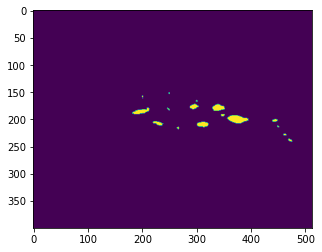

In [57]:

imthr = data3d > threshold
imshow(imthr[int(imthr.shape[0]/2),:,:])

In [58]:
import sed3
sed3.ipy_show_slices(imthr)

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice_number', max=45), IntSlid…

<function sed3.sed3.ipy_show_slices.<locals>.nbw_show_slices_fcn(image, slice_number, contour, seeds, axis)>

# Do the skeleton analysis

## Get the skeleton and find the nodes

In [59]:
volume_data = imthr
t0 = time.time()
skelet = skelet3d.skelet3d(volume_data)
print(time.time()-t0)

# skan = skelet3d.SkeletonAnalyser(skelet, volume_data=volume_data, voxelsize_mm=datap["voxelsize_mm"])
t0 = time.time()
skan = skelet3d.SkeletonAnalyser(
    skelet, 
#     volume_data=volume_data, 
    voxelsize_mm=datap["voxelsize_mm"],
    cut_wrong_skeleton=False
)
print(time.time()-t0)
# skan.

2021-10-26 20:01:24.056 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-26 20:01:24.056 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel


3.869603157043457


2021-10-26 20:01:24.726 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[5.0, 0.474609, 0.474609] volumedata:False
2021-10-26 20:01:24.726 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s


0.6709115505218506


## Check the volumetric labeled skeleton data

`sklabel` is 3d array where the value is label. Positive labels are tube segments, negative labels are nodes.

* 0: nothing - backgroud
* 1: First tube segment
* 2: second tube segment
* ...
* -1: First node
* -2: second node

![sklabel](../graphics/sklabel.png)

In [60]:
skan.sklabel.dtype

dtype('int32')

In [61]:

# sklabel_nodes = skan.sklabel.copy()
# sklabel_nodes[sklabel_nodes > 0] = 0
nz = np.nonzero(skan.sklabel < 0)
nz

(array([ 4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,
         7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 

In [62]:
voxelsize_mm = datap["voxelsize_mm"]

dfs = pd.DataFrame({
    "node_0_px":nz[0],
    "node_1_px":nz[1],
    "node_2_px":nz[2],
    "node_0_mm":nz[0]*voxelsize_mm[0],
    "node_1_mm":nz[1]*voxelsize_mm[1],
    "node_2_mm":nz[2]*voxelsize_mm[2],
})
dfs.to_csv(str(opth1) + ".nodes.csv")
# df["Z_px"]

In [63]:
io3d.write(skan.sklabel, str(opth1) + ".sklabel.mhd")
io3d.write(skan.sklabel, str(opth1) + ".imthr.mhd")

In [64]:
!ls

example_corrosion_cast_analysis.ipynb
example01.py
example02.py
example03.py
ITK+Skelet3D_dll
pokus.mhd
pokus.raw


In [65]:
# io3d.write({"data3d"})
np.savez(str(opth1) + ".npz", sklabel=skan.sklabel, imthr=imthr)

In [66]:

# dir(skan)#.__connection_analysis
# skan._SkeletonAnalyser__connection_analysis(3)

# Time consuming steps - radius analysis

In [67]:
t0 = time.time()
# skan.cut_wrong_skeleton = False
skan.volume_data = volume_data
stats = skan.skeleton_analysis()
print(time.time()-t0)

2021-10-26 20:01:25.282 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:130 - len_edg: 340 len_node: -520
2021-10-26 20:01:25.283 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:133 - __radius_analysis_init
2021-10-26 20:01:27.440 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:138 - skeleton_analysis: starting element_neighbors processing
2021-10-26 20:01:27.441 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbors:953 - Generating shifted sklabel...
2021-10-26 20:01:27.613 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8/861, part generating node->connected_edges lookup table
2021-10-26 20:01:27.757 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 16/861, part generating node->connected_edges lookup table
2021-10-26 20:01:27.895 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 24/861, part generating node->connected_edges loo

2021-10-26 20:01:34.148 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 368/861, part generating node->connected_edges lookup table
2021-10-26 20:01:34.297 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 376/861, part generating node->connected_edges lookup table
2021-10-26 20:01:34.438 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 384/861, part generating node->connected_edges lookup table
2021-10-26 20:01:34.583 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 392/861, part generating node->connected_edges lookup table
2021-10-26 20:01:34.724 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 400/861, part generating node->connected_edges lookup table
2021-10-26 20:01:34.865 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 408/861, part ge

2021-10-26 20:01:40.511 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 752/861, part generating node->connected_edges lookup table
2021-10-26 20:01:40.634 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 760/861, part generating node->connected_edges lookup table
2021-10-26 20:01:40.758 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 768/861, part generating node->connected_edges lookup table
2021-10-26 20:01:40.882 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 776/861, part generating node->connected_edges lookup table
2021-10-26 20:01:41.007 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 784/861, part generating node->connected_edges lookup table
2021-10-26 20:01:41.131 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 792/861, part ge

2021-10-26 20:01:46.774 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 96/340, part length, radius, curve, connections of edge
2021-10-26 20:01:46.919 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 99/340, part length, radius, curve, connections of edge
2021-10-26 20:01:47.058 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 102/340, part length, radius, curve, connections of edge
2021-10-26 20:01:47.194 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 105/340, part length, radius, curve, connections of edge
2021-10-26 20:01:47.335 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 108/340, part length, radius, curve, connections of edge
2021-10-26 20:01:47.477 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 111/340, part length, radius, cur

2021-10-26 20:01:54.134 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 240/340, part length, radius, curve, connections of edge
2021-10-26 20:01:54.284 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 243/340, part length, radius, curve, connections of edge
2021-10-26 20:01:54.425 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 246/340, part length, radius, curve, connections of edge
2021-10-26 20:01:54.582 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 249/340, part length, radius, curve, connections of edge
2021-10-26 20:01:54.738 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 252/340, part length, radius, curve, connections of edge
2021-10-26 20:01:54.893 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 255/340, part length, radius, c

2021-10-26 20:01:59.232 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.233 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.239 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.239 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.245 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.246 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.252 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.253 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.258 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.259 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.265 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.266 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.272 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.273 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.279 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.279 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.285 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.286 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.292 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.292 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.298 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.299 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.304 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.305 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.311 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.312 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.318 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.318 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.324 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.325 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.331 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.332 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.338 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.339 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.345 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.346 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.352 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.353 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.359 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.360 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.366 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.367 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.374 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.375 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.383 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.384 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.391 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.391 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.399 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.400 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.408 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.409 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.416 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.417 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.424 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.425 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.431 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.432 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.438 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.439 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.445 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.446 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.452 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 20:01:59.452 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 20:01:59.459 | DEBUG    | skelet3d.skeleton_analyser:__connected_edge_angle_on_one_end:798 - Vector key vectorA not found for edge 290.
2021-10-26 20:01:59.459 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".for

34.20878458023071


In [68]:



    
df = stats_as_dataframe(skan)

In [69]:
df.keys()

Index(['id', 'nodeIdA', 'nodeIdB', 'nodeA_ZYX 0', 'nodeA_ZYX 1', 'nodeA_ZYX 2',
       'nodeB_ZYX 0', 'nodeB_ZYX 1', 'nodeB_ZYX 2', 'nodeA_ZYX_mm 0',
       'nodeA_ZYX_mm 1', 'nodeA_ZYX_mm 2', 'nodeB_ZYX_mm 0', 'nodeB_ZYX_mm 1',
       'nodeB_ZYX_mm 2', 'orderedPoints_mm_X', 'orderedPoints_mm_Y',
       'orderedPoints_mm_Z', 'orderedPoints_mm', 'lengthEstimationPixel',
       'curve_params start 0', 'curve_params start 1', 'curve_params start 2',
       'curve_params vector 0', 'curve_params vector 1',
       'curve_params vector 2', 'curve_params fitParamsX 0',
       'curve_params fitParamsX 1', 'curve_params fitParamsX 2',
       'curve_params fitParamsY 0', 'curve_params fitParamsY 1',
       'curve_params fitParamsY 2', 'curve_params fitParamsZ 0',
       'curve_params fitParamsZ 1', 'curve_params fitParamsZ 2',
       'curve_params fitCurveStrX', 'curve_params fitCurveStrY',
       'curve_params fitCurveStrZ', 'lengthEstimationPoly',
       'lengthEstimationSpline', 'lengthEstima

In [70]:
datap["voxelsize_mm"]

[5.0, 0.474609, 0.474609]

In [71]:
dfs = df[["id", 
    "nodeA_ZYX 0", 
    "nodeA_ZYX 1", 
    "nodeA_ZYX 2", 
    "nodeB_ZYX 0",
    "nodeB_ZYX 1",
    "nodeB_ZYX 2",
    "nodeA_ZYX_mm 0", 
    "nodeA_ZYX_mm 1", 
    "nodeA_ZYX_mm 2", 
    "nodeB_ZYX_mm 0",
    "nodeB_ZYX_mm 1",
    "nodeB_ZYX_mm 2",
    "radius_mm",
    "connectedEdgesA 0",
    "connectedEdgesA 1",
    "connectedEdgesA 2",
    "connectedEdgesB 0",
    "connectedEdgesB 1",
    "connectedEdgesB 2",
   ]]

dfs

id  nodeA_ZYX 0  nodeA_ZYX 1  nodeA_ZYX 2  nodeB_ZYX 0  nodeB_ZYX 1  \
0      1          4.0        201.0        241.0          4.0        200.0   
1      2          9.0        190.0        285.0          5.0        192.0   
2      3         13.0        158.0        220.0          5.0        194.0   
3      4          5.0        222.0        287.0          5.0        221.0   
4      5         11.0        182.0        224.0          6.0        192.0   
..   ...          ...          ...          ...          ...          ...   
335  336         36.0        232.0        284.0         36.0        232.0   
336  337         37.0        240.0        300.0         37.0        236.0   
337  338         38.0        218.0        331.0         38.0        216.0   
338  339         38.0        234.0        402.0         38.0        234.0   
339  340         38.0        237.0        380.0         38.0        237.0   

     nodeB_ZYX 2  nodeA_ZYX_mm 0  nodeA_ZYX_mm 1  nodeA_ZYX_mm 2  \
0          236.0            20.0       95.396409      114.380769   
1          248.0            45.0       90.175710      135.263565   
2          225.0            65.0       74.988222      104.413980   
3          285.0            25.0      105.363198      136.212783   
4          210.0            55.0       86.378838      106.312416   
..           ...             ...             ...             ...   
335        282.0           180.0      110.109288      134.788956   
336        301.0           185.0      113.906160      142.382700   
337        331.0           190.0      103.464762      157.095579   
338        400.0           190.0      111.058506      190.792818   
339        378.0           190.0      112.482333      180.351420   

     nodeB_ZYX_mm 0  nodeB_ZYX_mm 1  nodeB_ZYX_mm 2  radius_mm  \
0              20.0       94.921800      112.007724   0.474609   
1              25.0       91.124928      117.703032   0.704953   
2              25.0       92.074146      106.787025   1.248332   
3              25.0      104.888589      135.263565   0.474609   
4              30.0       91.124928       99.667890   1.013491   
..              ...             ...             ...        ...   
335           180.0      110.109288      133.839738   0.474609   
336           185.0      112.007724      142.857309   0.949218   
337           190.0      102.515544      157.095579   0.671198   
338           190.0      111.058506      189.843600   0.474609   
339           190.0      112.482333      179.402202   0.949218   

     connectedEdgesA 0  connectedEdgesA 1  connectedEdgesA 2  \
0                  NaN                NaN                NaN   
1                 24.0               39.0                NaN   
2                 60.0               78.0                NaN   
3                  NaN                NaN                NaN   
4                  NaN                NaN                NaN   
..                 ...                ...                ...   
335                NaN                NaN                NaN   
336                NaN                NaN                NaN   
337                NaN                NaN                NaN   
338                NaN                NaN                NaN   
339                NaN                NaN                NaN   

     connectedEdgesB 0  connectedEdgesB 1  connectedEdgesB 2  
0                  NaN                NaN                NaN  
1                  NaN                NaN                NaN  
2                  NaN                NaN                NaN  
3                  NaN                NaN                NaN  
4                  NaN                NaN                NaN  
..                 ...                ...                ...  
335                NaN                NaN                NaN  
336                NaN                NaN                NaN  
337                NaN                NaN                NaN  
338                NaN                NaN                NaN  
339      

In [72]:


dfs.to_csv(str(opth1) + ".csv")

In [140]:
df[["id", "lengthEstimation", "radius_mm", "tortuosity",
#     'phiAc', "phiBa", "phiBb", 
    'connectedEdgesA 0', 'connectedEdgesA 1',
    'connectedEdgesB 0', 'connectedEdgesB 1',
    'connectedEdgesA 2',
       'connectedEdgesA 3',
       'connectedEdgesB 2', 'connectedEdgesB 3']]

id  lengthEstimation  radius_mm  tortuosity  connectedEdgesA 0  \
0      1          1.663841   0.474609    1.108602                NaN   
1      2         30.438152   0.704953    1.142908               22.0   
2      3         44.651448   1.248332    1.025033               54.0   
3      4         27.878795   1.038047    1.064733                NaN   
4      5         21.597572   0.628508    1.071167               29.0   
..   ...               ...        ...         ...                ...   
293  294          2.575768   0.523756    1.085428                NaN   
294  295         12.521959   0.865931    1.317747                NaN   
295  296         21.717960   0.962546    1.025528                NaN   
296  297          1.342397   0.474609    1.000000                NaN   
297  298          1.145807   0.949218    1.079669                NaN   

     connectedEdgesA 1  connectedEdgesB 0  connectedEdgesB 1  \
0                  NaN                NaN                NaN   
1                 36.0                NaN                NaN   
2                 71.0                NaN                NaN   
3                  NaN                NaN                NaN   
4                 40.0                NaN                NaN   
..                 ...                ...                ...   
293                NaN                NaN                NaN   
294                NaN              282.0              296.0   
295                NaN              282.0              295.0   
296                NaN                NaN                NaN   
297                NaN                NaN                NaN   

     connectedEdgesA 2  connectedEdgesA 3  connectedEdgesB 2  \
0                  NaN                NaN                NaN   
1                  NaN                NaN                NaN   
2                  NaN                NaN                NaN   
3                  NaN                NaN                NaN   
4                  NaN                NaN                NaN   
..                 ...                ...                ...   
293                NaN                NaN                NaN   
294                NaN                NaN                NaN   
295                NaN                NaN                NaN   
296                NaN                NaN                NaN   
297                NaN                NaN                NaN   

     connectedEdgesB 3  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
..                 ...  
293                NaN  
294                NaN  
295                NaN  
296                NaN  
297                NaN  

[298 rows x 12 columns]

## Angles expained
A bifurcation with the radii, lengths, and angles.

<img src="../graphics/bifurcation_angles_Schwen2012.png"></img>

Schwen, L. O., & Preusser, T. (2012). Analysis and algorithmic generation of hepatic vascular systems. International Journal of Hepatology, 2012, 357687. https://doi.org/10.1155/2012/357687

# Bulk processing

In [143]:
import glob
# pths = glob.glob("C:/Users/Jirik/Downloads/porcine_liver_ct_raw/*.mhd")
pth = Path(io3d.datasets.join_path("medical/processed/porcine_liver_ct_raw", get_root=True))
opth = Path(io3d.datasets.joinp("medical/processed/liver_portal_vein_ct_raw"))
pths = pth.glob("*.mhd")
# pth1 = pth / "P01_MakroCT_HEAD_5_0_H31S_0004.mhd"
# pth1
pths


<generator object Path.glob at 0x0000023736F73DC8>

In [144]:
for pth1 in pths:
# if True:
    opth1 = opth / pth1.stem / pth1.stem
    vessel_processing_mhd(pth1, opth1)


2021-10-27 08:42:12.178 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 08:42:12.179 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 08:42:13.254 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[5.0, 0.474609, 0.474609] volumedata:True
2021-10-27 08:42:13.255 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 08:42:13.256 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 08:42:13.275 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 186 len_node: -142
2021-10-27 08:42:13.276 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 08:42:13.277 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbors:953 - Generati

2021-10-27 08:42:27.267 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -128 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 08:42:27.300 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0  140    0    0    0    0]
  [   0  140    0    0    0    0]
  [ 140    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0 -101 -101    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    

2021-10-27 08:42:32.212 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 69/328, part generating node->connected_edges lookup table
2021-10-27 08:42:32.277 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 72/328, part generating node->connected_edges lookup table
2021-10-27 08:42:32.340 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 75/328, part generating node->connected_edges lookup table
2021-10-27 08:42:32.403 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 78/328, part generating node->connected_edges lookup table
2021-10-27 08:42:32.466 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 81/328, part generating node->connected_edges lookup table
2021-10-27 08:42:32.530 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 84/328, part generati

2021-10-27 08:42:35.124 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 213/328, part generating node->connected_edges lookup table
2021-10-27 08:42:35.182 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 216/328, part generating node->connected_edges lookup table
2021-10-27 08:42:35.239 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 219/328, part generating node->connected_edges lookup table
2021-10-27 08:42:35.300 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 222/328, part generating node->connected_edges lookup table
2021-10-27 08:42:35.356 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 225/328, part generating node->connected_edges lookup table
2021-10-27 08:42:35.412 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 228/328, part ge

2021-10-27 08:42:37.723 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 7/186, part length, radius, curve, connections of edge
2021-10-27 08:42:37.779 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8/186, part length, radius, curve, connections of edge
2021-10-27 08:42:37.837 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 9/186, part length, radius, curve, connections of edge
2021-10-27 08:42:37.894 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 10/186, part length, radius, curve, connections of edge
2021-10-27 08:42:37.950 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 11/186, part length, radius, curve, connections of edge
2021-10-27 08:42:38.006 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 12/186, part length, radius, curve, con

2021-10-27 08:42:40.499 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 53/186, part length, radius, curve, connections of edge
2021-10-27 08:42:40.550 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 54/186, part length, radius, curve, connections of edge
2021-10-27 08:42:40.601 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 55/186, part length, radius, curve, connections of edge
2021-10-27 08:42:40.655 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 56/186, part length, radius, curve, connections of edge
2021-10-27 08:42:40.710 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 57/186, part length, radius, curve, connections of edge
2021-10-27 08:42:40.775 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 58/186, part length, radius, curve, 

2021-10-27 08:42:43.523 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 102/186, part length, radius, curve, connections of edge
2021-10-27 08:42:43.575 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 103/186, part length, radius, curve, connections of edge
2021-10-27 08:42:43.626 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 104/186, part length, radius, curve, connections of edge
2021-10-27 08:42:43.688 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 105/186, part length, radius, curve, connections of edge
2021-10-27 08:42:43.751 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 106/186, part length, radius, curve, connections of edge
2021-10-27 08:42:43.814 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 107/186, part length, radius, c

2021-10-27 08:42:45.872 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 141. No length computation.
2021-10-27 08:42:45.906 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0  140    0    0    0    0]
  [   0  140    0    0    0    0]
  [ 140    0    0    0    0    0]]

 [[   0    0    0    0    0    0]


2021-10-27 08:42:48.106 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 178/186, part length, radius, curve, connections of edge
2021-10-27 08:42:48.163 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 179/186, part length, radius, curve, connections of edge
2021-10-27 08:42:48.219 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 180/186, part length, radius, curve, connections of edge
2021-10-27 08:42:48.275 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 181/186, part length, radius, curve, connections of edge
2021-10-27 08:42:48.337 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 182/186, part length, radius, curve, connections of edge
2021-10-27 08:42:48.393 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 183/186, part length, radius, c

2021-10-27 08:42:48.574 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 08:42:48.575 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 08:42:48.582 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 08:42:48.583 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 08:42:48.589 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 08:42:48.590 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 08:42:48.596 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 08:42:48.597 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 08:42:48.611 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 63/186, part angles of connected edges
2021-10-27 08:42:48.611 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 64/186, part angles of connected edges
2021-10-27 08:42:48.612 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 65/186, part angles of connected edges
2021-10-27 08:42:48.612 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 66/186, part angles of connected edges
2021-10-27 08:42:48.612 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 67/186, part angles of connected edges
2021-10-27 08:42:48.613 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 68/186, part angles of connected edges
2021-10-27 08:42:48.614 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-27 08:42:48.635 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 117/186, part angles of connected edges
2021-10-27 08:42:48.635 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 118/186, part angles of connected edges
2021-10-27 08:42:48.636 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 119/186, part angles of connected edges
2021-10-27 08:42:48.636 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 120/186, part angles of connected edges
2021-10-27 08:42:48.637 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 121/186, part angles of connected edges
2021-10-27 08:42:48.637 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 122/186, part angles of connected edges
2021-10-27 08:42:48.637 | INFO     | skelet3d.skeleton_analyser:updateFuncti

2021-10-27 08:42:48.659 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 171/186, part angles of connected edges
2021-10-27 08:42:48.659 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 172/186, part angles of connected edges
2021-10-27 08:42:48.660 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 173/186, part angles of connected edges
2021-10-27 08:42:48.660 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 174/186, part angles of connected edges
2021-10-27 08:42:48.660 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 175/186, part angles of connected edges
2021-10-27 08:42:48.661 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 176/186, part angles of connected edges
2021-10-27 08:42:48.661 | INFO     | skelet3d.skeleton_analyser:updateFuncti

2021-10-27 08:43:09.155 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 166 with its nodes [-231 -230]
2021-10-27 08:43:09.173 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 176 with its nodes [-239 -237]
2021-10-27 08:43:09.191 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 181 with its nodes [-268 -252]
2021-10-27 08:43:09.208 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 182 with its nodes [-270 -253]
2021-10-27 08:43:09.226 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 188 with its nodes [-257 -256]
2021-10-27 08:43:09.243 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 192 with its nodes [-264 -263]
2021-10-27 08:43:09.260 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_

2021-10-27 08:43:10.055 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -478
2021-10-27 08:43:10.065 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -477
2021-10-27 08:43:10.074 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -472
2021-10-27 08:43:10.083 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -469
2021-10-27 08:43:10.094 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -468
2021-10-27 08:43:10.103 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -467
2021-10-27 08:43:10.114 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -465
2021-10-27 08:43:10.123 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 

2021-10-27 08:43:10.705 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -200
2021-10-27 08:43:10.714 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -191
2021-10-27 08:43:10.723 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -184
2021-10-27 08:43:10.734 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -183
2021-10-27 08:43:10.744 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -181
2021-10-27 08:43:10.754 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -173
2021-10-27 08:43:10.764 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -168
2021-10-27 08:43:10.774 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 

2021-10-27 08:43:14.319 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:14.363 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:14.408 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:14.454 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:14.492 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:14.530 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:14.568 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:14.609 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340


2021-10-27 08:43:17.302 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:17.357 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:17.405 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:17.455 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:17.497 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:17.545 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:17.598 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340
2021-10-27 08:43:17.654 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=340


2021-10-27 08:43:19.301 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0  266    0    0    0]
  [   0    0    0  266    0  

2021-10-27 08:43:19.388 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -107 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 08:43:19.419 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  

2021-10-27 08:43:24.873 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/665, part generating node->connected_edges lookup table
2021-10-27 08:43:24.975 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 150/665, part generating node->connected_edges lookup table
2021-10-27 08:43:25.084 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 156/665, part generating node->connected_edges lookup table
2021-10-27 08:43:25.196 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 162/665, part generating node->connected_edges lookup table
2021-10-27 08:43:25.307 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 168/665, part generating node->connected_edges lookup table
2021-10-27 08:43:25.417 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 174/665, part ge

2021-10-27 08:43:29.604 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 432/665, part generating node->connected_edges lookup table
2021-10-27 08:43:29.701 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 438/665, part generating node->connected_edges lookup table
2021-10-27 08:43:29.797 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 444/665, part generating node->connected_edges lookup table
2021-10-27 08:43:29.887 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 450/665, part generating node->connected_edges lookup table
2021-10-27 08:43:29.974 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 456/665, part generating node->connected_edges lookup table
2021-10-27 08:43:30.059 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 462/665, part ge

2021-10-27 08:43:33.629 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 14/298, part length, radius, curve, connections of edge
2021-10-27 08:43:33.713 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 16/298, part length, radius, curve, connections of edge
2021-10-27 08:43:33.799 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 18/298, part length, radius, curve, connections of edge
2021-10-27 08:43:33.884 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 20/298, part length, radius, curve, connections of edge
2021-10-27 08:43:33.978 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 22/298, part length, radius, curve, connections of edge
2021-10-27 08:43:34.064 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 24/298, part length, radius, curve, 

2021-10-27 08:43:36.805 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 88/298, part length, radius, curve, connections of edge
2021-10-27 08:43:36.889 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 90/298, part length, radius, curve, connections of edge
2021-10-27 08:43:36.973 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 92/298, part length, radius, curve, connections of edge
2021-10-27 08:43:37.062 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 94/298, part length, radius, curve, connections of edge
2021-10-27 08:43:37.154 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 96/298, part length, radius, curve, connections of edge
2021-10-27 08:43:37.240 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 98/298, part length, radius, curve, 

2021-10-27 08:43:41.090 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 184/298, part length, radius, curve, connections of edge
2021-10-27 08:43:41.183 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 186/298, part length, radius, curve, connections of edge
2021-10-27 08:43:41.273 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 188/298, part length, radius, curve, connections of edge
2021-10-27 08:43:41.366 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 190/298, part length, radius, curve, connections of edge
2021-10-27 08:43:41.465 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 192/298, part length, radius, curve, connections of edge
2021-10-27 08:43:41.562 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 194/298, part length, radius, c

2021-10-27 08:43:44.562 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 260/298, part length, radius, curve, connections of edge
2021-10-27 08:43:44.650 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 262/298, part length, radius, curve, connections of edge
2021-10-27 08:43:44.693 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-287]) connected node in connection_analysis() for edge number 264
2021-10-27 08:43:44.693 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 264. No length computation.
2021-10-27 08:43:44.720 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0

2021-10-27 08:43:46.257 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:198 - skeleton_analysis: starting processing part: angles of connected edges
2021-10-27 08:43:46.258 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
  

2021-10-27 08:43:46.266 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 08:43:46.267 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 08:43:46.273 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 08:43:46.274 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 08:43:46.281 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 28/298, part angles of connected edges
2021-10-27 08:43:46.281 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 30/298, part angles of connected edges
2021-10-27 08:43:46.282 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 32/298, part angles of connected edges
2021-10-27 08:43:46.282 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 34/298, part angles of connected edges
2021-10-27 08:43:46.283 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 36/298, part angles of connected edges
2021-10-27 08:43:46.283 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 38/298, part angles of connected edges
2021-10-27 08:43:46.284 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-27 08:43:46.305 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 136/298, part angles of connected edges
2021-10-27 08:43:46.306 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 138/298, part angles of connected edges
2021-10-27 08:43:46.306 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 140/298, part angles of connected edges
2021-10-27 08:43:46.307 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 142/298, part angles of connected edges
2021-10-27 08:43:46.307 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/298, part angles of connected edges
2021-10-27 08:43:46.308 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 146/298, part angles of connected edges
2021-10-27 08:43:46.308 | INFO     | skelet3d.skeleton_analyser:updateFuncti

2021-10-27 08:43:46.327 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 244/298, part angles of connected edges
2021-10-27 08:43:46.328 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 246/298, part angles of connected edges
2021-10-27 08:43:46.328 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 248/298, part angles of connected edges
2021-10-27 08:43:46.328 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 250/298, part angles of connected edges
2021-10-27 08:43:46.329 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 252/298, part angles of connected edges
2021-10-27 08:43:46.329 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 254/298, part angles of connected edges
2021-10-27 08:43:46.330 | INFO     | skelet3d.skeleton_analyser:updateFuncti

2021-10-27 10:05:35.363 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 75 with its nodes [-146 -132]
2021-10-27 10:05:35.702 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 92 with its nodes [-186 -165]
2021-10-27 10:05:36.021 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 102 with its nodes [-195 -177]
2021-10-27 10:05:36.346 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 110 with its nodes [-209 -198]
2021-10-27 10:05:36.668 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 115 with its nodes [-231 -222]
2021-10-27 10:05:36.990 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 139 with its nodes [-259 -249]
2021-10-27 10:05:37.321 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_ed

2021-10-27 10:05:53.389 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 448 with its nodes [-743 -736]
2021-10-27 10:05:53.732 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 450 with its nodes [-783 -727]
2021-10-27 10:05:54.054 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 461 with its nodes [-800 -748]
2021-10-27 10:05:54.385 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 473 with its nodes [-815 -768]
2021-10-27 10:05:54.719 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 477 with its nodes [-776 -775]
2021-10-27 10:05:55.046 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 482 with its nodes [-792 -785]
2021-10-27 10:05:55.374 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_

2021-10-27 10:06:11.838 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 728 with its nodes [-1191 -1169]
2021-10-27 10:06:12.162 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 729 with its nodes [-1182 -1174]
2021-10-27 10:06:12.490 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 730 with its nodes [-1187 -1186]
2021-10-27 10:06:12.811 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 738 with its nodes [-1200 -1199]
2021-10-27 10:06:13.134 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 740 with its nodes [-1231 -1208]
2021-10-27 10:06:13.457 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 741 with its nodes [-1211 -1210]
2021-10-27 10:06:13.787 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skelet

2021-10-27 10:06:29.514 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 972 with its nodes [-1650 -1631]
2021-10-27 10:06:29.842 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 986 with its nodes [-1626 -1619]
2021-10-27 10:06:30.193 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 989 with its nodes [-1624 -1623]
2021-10-27 10:06:30.562 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1000 with its nodes [-1684 -1628]
2021-10-27 10:06:30.888 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1001 with its nodes [-1648 -1647]
2021-10-27 10:06:31.220 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1006 with its nodes [-1664 -1642]
2021-10-27 10:06:31.562 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_ske

2021-10-27 10:06:49.512 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1309 with its nodes [-2139 -2127]
2021-10-27 10:06:49.838 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1310 with its nodes [-2151 -2114]
2021-10-27 10:06:50.161 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1313 with its nodes [-2145 -2115]
2021-10-27 10:06:50.487 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1315 with its nodes [-2147 -2132]
2021-10-27 10:06:50.806 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1317 with its nodes [-2150 -2124]
2021-10-27 10:06:51.139 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1318 with its nodes [-2172 -2135]
2021-10-27 10:06:51.470 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_

2021-10-27 10:07:07.477 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1599 with its nodes [-2622 -2620]
2021-10-27 10:07:07.806 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1601 with its nodes [-2628 -2627]
2021-10-27 10:07:08.136 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1606 with its nodes [-2671 -2651]
2021-10-27 10:07:08.455 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1621 with its nodes [-2669 -2668]
2021-10-27 10:07:08.780 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1633 with its nodes [-2692 -2679]
2021-10-27 10:07:09.119 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 1636 with its nodes [-2767 -2672]
2021-10-27 10:07:09.458 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_

2021-10-27 10:07:26.852 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2008 with its nodes [-3189 -3188]
2021-10-27 10:07:27.521 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2028 with its nodes [-3308 -3178]
2021-10-27 10:07:27.855 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2030 with its nodes [-3267 -3183]
2021-10-27 10:07:28.215 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2035 with its nodes [-3216 -3214]
2021-10-27 10:07:28.555 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2038 with its nodes [-3291 -3217]
2021-10-27 10:07:28.877 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2049 with its nodes [-3331 -3202]
2021-10-27 10:07:29.193 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_

2021-10-27 10:07:44.907 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2720 with its nodes [-3969 -3968]
2021-10-27 10:07:45.233 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2732 with its nodes [-3977 -3976]
2021-10-27 10:07:45.577 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2738 with its nodes [-3980 -3979]
2021-10-27 10:07:45.911 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2786 with its nodes [-4037 -4036]
2021-10-27 10:07:46.253 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2789 with its nodes [-4088 -4045]
2021-10-27 10:07:46.611 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 2802 with its nodes [-4129 -4057]
2021-10-27 10:07:46.957 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_

2021-10-27 10:08:02.988 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 3465 with its nodes [-4835 -4834]
2021-10-27 10:08:03.328 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 3492 with its nodes [-4875]
2021-10-27 10:08:03.505 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 3499 with its nodes [-4858 -4838]
2021-10-27 10:08:03.845 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 3540 with its nodes [-4950 -4885]
2021-10-27 10:08:04.179 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 3551 with its nodes [-4943 -4922]
2021-10-27 10:08:04.523 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 3581 with its nodes [-4956 -4955]
2021-10-27 10:08:04.858 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skelet

2021-10-27 10:08:21.343 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 4086 with its nodes [-5719 -5700]
2021-10-27 10:08:21.667 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 4089 with its nodes [-5711 -5697]
2021-10-27 10:08:21.992 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 4090 with its nodes [-5716 -5699]
2021-10-27 10:08:22.327 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 4091 with its nodes [-5717 -5706]
2021-10-27 10:08:22.656 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 4095 with its nodes [-5726 -5705]
2021-10-27 10:08:22.981 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:362 - removing edge 4098 with its nodes [-5745 -5720]
2021-10-27 10:08:23.328 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_

2021-10-27 10:08:35.546 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -6423
2021-10-27 10:08:35.708 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -6416
2021-10-27 10:08:35.868 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -6401
2021-10-27 10:08:36.027 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -6387
2021-10-27 10:08:36.196 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -6385
2021-10-27 10:08:36.361 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -6384
2021-10-27 10:08:36.529 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -6378
2021-10-27 10:08:36.691 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:08:46.035 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5850
2021-10-27 10:08:46.201 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5841
2021-10-27 10:08:46.366 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5839
2021-10-27 10:08:46.530 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5838
2021-10-27 10:08:46.697 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5837
2021-10-27 10:08:46.880 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5825
2021-10-27 10:08:47.039 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5823
2021-10-27 10:08:47.204 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:08:56.486 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5634
2021-10-27 10:08:56.647 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5630
2021-10-27 10:08:56.813 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5625
2021-10-27 10:08:56.971 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5624
2021-10-27 10:08:57.140 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5621
2021-10-27 10:08:57.305 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5620
2021-10-27 10:08:57.475 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5619
2021-10-27 10:08:57.636 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:09:06.982 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5458
2021-10-27 10:09:07.151 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5457
2021-10-27 10:09:07.317 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5452
2021-10-27 10:09:07.477 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5451
2021-10-27 10:09:07.642 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5448
2021-10-27 10:09:07.803 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5439
2021-10-27 10:09:07.961 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5438
2021-10-27 10:09:08.124 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:09:17.577 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5213
2021-10-27 10:09:17.738 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5208
2021-10-27 10:09:17.896 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5206
2021-10-27 10:09:18.056 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5205
2021-10-27 10:09:18.218 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5204
2021-10-27 10:09:18.382 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5202
2021-10-27 10:09:18.551 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5194
2021-10-27 10:09:18.712 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:09:28.055 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5019
2021-10-27 10:09:28.232 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5018
2021-10-27 10:09:28.394 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5015
2021-10-27 10:09:28.555 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5014
2021-10-27 10:09:28.722 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5010
2021-10-27 10:09:28.886 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5006
2021-10-27 10:09:29.048 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -5005
2021-10-27 10:09:29.212 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:09:38.454 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4797
2021-10-27 10:09:38.615 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4796
2021-10-27 10:09:38.779 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4793
2021-10-27 10:09:38.938 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4787
2021-10-27 10:09:39.090 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4779
2021-10-27 10:09:39.256 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4777
2021-10-27 10:09:39.418 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4773
2021-10-27 10:09:39.580 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:09:48.729 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4550
2021-10-27 10:09:48.886 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4544
2021-10-27 10:09:49.048 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4543
2021-10-27 10:09:49.207 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4541
2021-10-27 10:09:49.366 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4540
2021-10-27 10:09:49.528 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4533
2021-10-27 10:09:49.689 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4530
2021-10-27 10:09:49.852 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:09:59.228 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4314
2021-10-27 10:09:59.397 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4312
2021-10-27 10:09:59.558 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4311
2021-10-27 10:09:59.719 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4309
2021-10-27 10:09:59.879 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4308
2021-10-27 10:10:00.034 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4300
2021-10-27 10:10:00.195 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4292
2021-10-27 10:10:00.365 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:10:10.876 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4091
2021-10-27 10:10:11.029 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4087
2021-10-27 10:10:11.189 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4081
2021-10-27 10:10:11.356 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4073
2021-10-27 10:10:11.519 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4072
2021-10-27 10:10:11.767 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4046
2021-10-27 10:10:11.981 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -4044
2021-10-27 10:10:12.196 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:10:22.217 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3837
2021-10-27 10:10:22.381 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3832
2021-10-27 10:10:22.544 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3830
2021-10-27 10:10:22.707 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3827
2021-10-27 10:10:22.872 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3824
2021-10-27 10:10:23.027 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3822
2021-10-27 10:10:23.196 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3808
2021-10-27 10:10:23.361 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:10:33.176 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3565
2021-10-27 10:10:33.340 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3562
2021-10-27 10:10:33.499 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3560
2021-10-27 10:10:33.666 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3559
2021-10-27 10:10:33.828 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3557
2021-10-27 10:10:33.984 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3552
2021-10-27 10:10:34.164 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3551
2021-10-27 10:10:34.326 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:10:43.664 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3404
2021-10-27 10:10:43.837 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3398
2021-10-27 10:10:44.002 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3397
2021-10-27 10:10:44.168 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3396
2021-10-27 10:10:44.334 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3395
2021-10-27 10:10:44.499 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3391
2021-10-27 10:10:44.661 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3390
2021-10-27 10:10:44.824 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:10:54.229 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3176
2021-10-27 10:10:54.397 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3162
2021-10-27 10:10:54.562 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3156
2021-10-27 10:10:54.725 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3154
2021-10-27 10:10:54.889 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3153
2021-10-27 10:10:55.048 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3150
2021-10-27 10:10:55.218 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -3137
2021-10-27 10:10:55.384 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:11:04.885 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2911
2021-10-27 10:11:05.042 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2910
2021-10-27 10:11:05.208 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2907
2021-10-27 10:11:05.376 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2906
2021-10-27 10:11:05.541 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2905
2021-10-27 10:11:05.707 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2899
2021-10-27 10:11:05.903 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2895
2021-10-27 10:11:06.069 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:11:15.386 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2706
2021-10-27 10:11:15.546 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2703
2021-10-27 10:11:15.710 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2698
2021-10-27 10:11:15.866 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2695
2021-10-27 10:11:16.026 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2694
2021-10-27 10:11:16.190 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2689
2021-10-27 10:11:16.359 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2688
2021-10-27 10:11:16.524 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:11:26.184 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2533
2021-10-27 10:11:26.347 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2532
2021-10-27 10:11:26.515 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2523
2021-10-27 10:11:26.678 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2515
2021-10-27 10:11:26.847 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2514
2021-10-27 10:11:27.008 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2508
2021-10-27 10:11:27.179 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2505
2021-10-27 10:11:27.346 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:11:37.303 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2335
2021-10-27 10:11:37.470 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2333
2021-10-27 10:11:37.633 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2332
2021-10-27 10:11:37.793 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2329
2021-10-27 10:11:37.958 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2328
2021-10-27 10:11:38.119 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2325
2021-10-27 10:11:38.280 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2324
2021-10-27 10:11:38.441 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:11:48.157 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2143
2021-10-27 10:11:48.323 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2141
2021-10-27 10:11:48.490 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2140
2021-10-27 10:11:48.654 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2136
2021-10-27 10:11:48.814 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2133
2021-10-27 10:11:48.975 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2131
2021-10-27 10:11:49.137 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -2128
2021-10-27 10:11:49.300 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:11:58.626 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1933
2021-10-27 10:11:58.795 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1932
2021-10-27 10:11:58.951 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1931
2021-10-27 10:11:59.110 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1929
2021-10-27 10:11:59.272 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1925
2021-10-27 10:11:59.438 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1923
2021-10-27 10:11:59.599 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1919
2021-10-27 10:11:59.767 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:12:09.095 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1720
2021-10-27 10:12:09.257 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1719
2021-10-27 10:12:09.421 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1717
2021-10-27 10:12:09.580 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1716
2021-10-27 10:12:09.741 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1715
2021-10-27 10:12:09.896 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1714
2021-10-27 10:12:10.065 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1708
2021-10-27 10:12:10.228 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:12:19.536 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1524
2021-10-27 10:12:19.700 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1523
2021-10-27 10:12:19.865 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1521
2021-10-27 10:12:20.026 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1520
2021-10-27 10:12:20.193 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1514
2021-10-27 10:12:20.358 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1511
2021-10-27 10:12:20.531 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1509
2021-10-27 10:12:20.694 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:12:30.026 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1326
2021-10-27 10:12:30.195 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1324
2021-10-27 10:12:30.367 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1321
2021-10-27 10:12:30.532 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1320
2021-10-27 10:12:30.700 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1310
2021-10-27 10:12:30.867 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1308
2021-10-27 10:12:31.031 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1306
2021-10-27 10:12:31.203 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:12:40.683 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1138
2021-10-27 10:12:40.851 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1135
2021-10-27 10:12:41.013 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1134
2021-10-27 10:12:41.176 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1133
2021-10-27 10:12:41.341 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1132
2021-10-27 10:12:41.501 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1131
2021-10-27 10:12:41.667 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -1125
2021-10-27 10:12:41.828 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edg

2021-10-27 10:12:51.129 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -907
2021-10-27 10:12:51.305 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -906
2021-10-27 10:12:51.482 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -905
2021-10-27 10:12:51.647 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -902
2021-10-27 10:12:51.836 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -886
2021-10-27 10:12:52.066 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -885
2021-10-27 10:12:52.591 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -883
2021-10-27 10:12:52.908 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 

2021-10-27 10:13:02.416 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -690
2021-10-27 10:13:02.581 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -687
2021-10-27 10:13:02.743 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -681
2021-10-27 10:13:02.900 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -680
2021-10-27 10:13:03.061 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -678
2021-10-27 10:13:03.227 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -674
2021-10-27 10:13:03.388 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -672
2021-10-27 10:13:03.549 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 

2021-10-27 10:13:13.508 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -503
2021-10-27 10:13:13.665 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -502
2021-10-27 10:13:13.830 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -501
2021-10-27 10:13:13.989 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -500
2021-10-27 10:13:14.150 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -498
2021-10-27 10:13:14.312 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -494
2021-10-27 10:13:14.477 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -490
2021-10-27 10:13:14.642 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 

2021-10-27 10:13:24.151 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -295
2021-10-27 10:13:24.318 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -290
2021-10-27 10:13:24.484 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -289
2021-10-27 10:13:24.648 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -287
2021-10-27 10:13:24.814 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -283
2021-10-27 10:13:24.972 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -281
2021-10-27 10:13:25.138 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -280
2021-10-27 10:13:25.306 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 

2021-10-27 10:13:34.801 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -121
2021-10-27 10:13:34.958 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -118
2021-10-27 10:13:35.114 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -114
2021-10-27 10:13:35.269 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -113
2021-10-27 10:13:35.433 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -109
2021-10-27 10:13:35.595 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -107
2021-10-27 10:13:35.772 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 - removing element -106
2021-10-27 10:13:35.929 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:375 

2021-10-27 10:15:02.729 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:03.498 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:04.280 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:05.113 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:05.905 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:06.684 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:07.450 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:08.246 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:15:53.758 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:54.529 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:55.304 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:56.101 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:56.873 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:57.628 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:58.397 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:15:59.173 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:16:47.362 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:16:48.165 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:16:48.950 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:16:49.752 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:16:50.661 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:16:51.600 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:16:52.521 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:16:53.350 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:17:41.648 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:17:42.433 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:17:43.211 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:17:44.001 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:17:44.748 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:17:45.532 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:17:46.310 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:17:47.105 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:18:33.080 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:18:33.875 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:18:34.655 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:18:35.439 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:18:36.213 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:18:37.000 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:18:37.776 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:18:38.550 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:19:25.735 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:19:26.504 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:19:27.278 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:19:28.090 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:19:28.921 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:19:29.762 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:19:30.527 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:19:31.334 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:20:19.204 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:20:20.021 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:20:20.840 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:20:21.626 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:20:22.408 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:20:23.201 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:20:24.039 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:20:25.244 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:21:13.594 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:21:14.374 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:21:15.169 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:21:15.989 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:21:16.773 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:21:17.541 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:21:18.314 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:21:19.109 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:22:06.049 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:22:06.928 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:22:07.686 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:22:08.462 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:22:09.254 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:22:10.148 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:22:11.003 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:22:11.813 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:22:58.312 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:22:59.112 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:22:59.932 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:00.682 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:01.453 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:02.244 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:03.045 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:03.845 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:23:50.558 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:51.345 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:52.151 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:52.957 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:53.751 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:54.513 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:55.303 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:23:56.110 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:24:44.888 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:24:45.640 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:24:46.446 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:24:47.399 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:24:48.291 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:24:49.129 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:24:50.053 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:24:50.886 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:25:38.398 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:25:39.194 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:25:40.021 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:25:40.873 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:25:41.629 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:25:42.462 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:25:43.721 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:25:44.801 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:26:34.628 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:26:35.479 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:26:36.361 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:26:37.225 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:26:38.092 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:26:38.949 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:26:39.807 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:26:40.601 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:27:32.116 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:27:33.114 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:27:33.955 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:27:34.722 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:27:35.557 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:27:36.390 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:27:37.200 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:27:38.022 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:28:26.961 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:28:27.791 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:28:28.585 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:28:29.382 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:28:30.191 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:28:31.034 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:28:31.891 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:28:32.659 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:29:21.063 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:29:21.952 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:29:22.705 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:29:23.527 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:29:24.405 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:29:25.256 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:29:26.131 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:29:27.005 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:30:16.625 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:30:17.413 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:30:18.235 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:30:19.070 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:30:19.917 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:30:20.679 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:30:21.460 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:30:22.268 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:31:10.386 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:31:11.220 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:31:12.060 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:31:12.920 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:31:13.674 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:31:14.480 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:31:15.292 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:31:16.106 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:32:05.274 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:32:06.099 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:32:06.965 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:32:07.809 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:32:08.611 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:32:09.421 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:32:10.236 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:32:11.072 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:33:00.199 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:33:01.271 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:33:02.256 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:33:03.142 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:33:04.026 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:33:04.987 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:33:06.001 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:33:06.856 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:33:57.284 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:33:58.104 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:33:58.942 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:33:59.790 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:00.583 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:01.425 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:02.270 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:03.115 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:34:51.237 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:52.063 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:52.901 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:53.648 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:54.457 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:55.335 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:56.574 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:34:57.486 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:35:46.515 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:35:47.363 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:35:48.214 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:35:49.059 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:35:49.932 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:35:50.836 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:35:51.612 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=5247
2021-10-27 10:35:52.469 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_numb

2021-10-27 10:35:59.988 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -6582 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:00.548 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0 -6508     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:02.096 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -6478 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:02.601 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:04.090 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -6280 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:04.571 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [-6233     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:06.042 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -6111 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:06.562 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0 -6074     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0  4514     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:07.983 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -5981 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:08.473 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[-5888     0]]

 [[    0 -5888]]

 [[    0     0]]

 [[-5888 -5888]]]
2021-10-27 10:36:08.474 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -5888 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:08.960 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0  4157     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0  

2021-10-27 10:36:10.414 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -5559 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:10.887 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [ 3958     0  3959     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0  3966     0     0]
  [    0     0     0  3966     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0  3959     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0 -5536     0     0]
  [    0     0 -5536     0     0     0]
  [    0     0     0     0     0     0

2021-10-27 10:36:12.362 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -5474 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:12.850 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [ 3843     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0  3843     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0 -5463 -5463  3922  3922]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0

2021-10-27 10:36:14.770 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -5321 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:15.265 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0 -5112     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:16.708 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -4994 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:17.185 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0  3348     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0  3348     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:18.621 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -4690 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:19.128 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0  3021  3021]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0 -4477 -4477     0     0]
  [    0     0     0     0     0     0

2021-10-27 10:36:20.605 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -4083 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:21.130 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [-3926     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:22.652 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -3805 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:23.183 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0 -3803     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0

2021-10-27 10:36:24.669 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -3672 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:25.164 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0  2262     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0 -3469     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [-3539     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:26.685 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -3525 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:27.215 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0  2170     0 -3276     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:28.777 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -3307 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:29.290 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:30.858 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -2993 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:31.376 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0  1540]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0  1540     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:33.498 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -2762 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:33.999 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:35.511 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -2659 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:36.012 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0  1564     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:37.476 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -2457 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:37.957 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:39.445 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -2065 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:39.914 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0 -1977     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0  1210     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:41.395 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -1687 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:41.889 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [ 1009     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0  1014     0     0]
  [    0     0     0     0  1014     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:43.350 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -1574 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:43.873 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0 -1539   942     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0   942     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:45.325 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -1463 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:45.799 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0   785]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  

2021-10-27 10:36:47.260 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -979 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:47.735 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0 -931]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [ 589  589    0    0  590    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0 -963 -963    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]

2021-10-27 10:36:49.654 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -875 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:50.124 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    

2021-10-27 10:36:52.043 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -401 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:52.529 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    

2021-10-27 10:36:54.316 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -253 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:54.808 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    

2021-10-27 10:36:56.933 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -3 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 10:36:56.934 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:419 - Regenerate new nodes and edges from cut skeleton
2021-10-27 10:37:10.111 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:130 - len_edg: 4868 len_node: -4342
2021-10-27 10:37:10.112 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:133 - __radius_analysis_init
2021-10-27 10:38:07.038 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:138 - skeleton_analysis: starting element_neighbors processing
2021-10-27 10:38:07.108 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbors:953 - Generating shifted sklabel...
2021-10-27 10:38:37.319 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 92/9211, part generating node

2021-10-27 10:59:45.640 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3956/9211, part generating node->connected_edges lookup table
2021-10-27 11:00:15.938 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4048/9211, part generating node->connected_edges lookup table
2021-10-27 11:00:46.093 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4140/9211, part generating node->connected_edges lookup table
2021-10-27 11:01:16.131 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4232/9211, part generating node->connected_edges lookup table
2021-10-27 11:01:46.595 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4324/9211, part generating node->connected_edges lookup table
2021-10-27 11:02:13.503 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4416/9

2021-10-27 11:21:06.282 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8280/9211, part generating node->connected_edges lookup table
2021-10-27 11:21:32.699 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8372/9211, part generating node->connected_edges lookup table
2021-10-27 11:21:59.344 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8464/9211, part generating node->connected_edges lookup table
2021-10-27 11:22:26.220 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8556/9211, part generating node->connected_edges lookup table
2021-10-27 11:22:54.507 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8648/9211, part generating node->connected_edges lookup table
2021-10-27 11:23:22.376 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8740/9

2021-10-27 11:27:49.337 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/4868, part length, radius, curve, connections of edge
2021-10-27 11:28:09.445 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-200]) connected node in connection_analysis() for edge number 169
2021-10-27 11:28:09.446 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 169. No length computation.
2021-10-27 11:28:09.925 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0  

2021-10-27 11:29:10.683 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 240/4868, part length, radius, curve, connections of edge
2021-10-27 11:29:52.499 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 288/4868, part length, radius, curve, connections of edge
2021-10-27 11:30:00.694 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-309]) connected node in connection_analysis() for edge number 299
2021-10-27 11:30:00.695 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 299. No length computation.
2021-10-27 11:30:01.189 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0 -309    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [  

2021-10-27 11:31:50.262 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 432/4868, part length, radius, curve, connections of edge
2021-10-27 11:32:26.127 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-519]) connected node in connection_analysis() for edge number 477
2021-10-27 11:32:26.127 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 477. No length computation.
2021-10-27 11:32:26.615 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0  

2021-10-27 11:33:11.494 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 528/4868, part length, radius, curve, connections of edge
2021-10-27 11:33:25.346 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-571]) connected node in connection_analysis() for edge number 546
2021-10-27 11:33:25.347 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 546. No length computation.
2021-10-27 11:33:25.828 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [ 525    0    0  

2021-10-27 11:33:52.508 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 576/4868, part length, radius, curve, connections of edge
2021-10-27 11:34:29.538 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-673]) connected node in connection_analysis() for edge number 621
2021-10-27 11:34:29.539 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 621. No length computation.
2021-10-27 11:34:30.040 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0  604]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0  621 -673    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]


2021-10-27 11:37:32.953 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0 -902    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0  826    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0 -922    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0  

2021-10-27 11:40:35.103 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1056/4868, part length, radius, curve, connections of edge
2021-10-27 11:41:03.390 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-1234]) connected node in connection_analysis() for edge number 1091
2021-10-27 11:41:03.391 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1091. No length computation.
2021-10-27 11:41:03.879 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0  1078]
  [  

2021-10-27 11:41:54.997 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1152/4868, part length, radius, curve, connections of edge
2021-10-27 11:42:39.250 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1200/4868, part length, radius, curve, connections of edge
2021-10-27 11:42:51.496 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-1360]) connected node in connection_analysis() for edge number 1215
2021-10-27 11:42:51.497 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1215. No length computation.
2021-10-27 11:42:52.041 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0  1188     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0  

2021-10-27 11:45:22.513 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1392/4868, part length, radius, curve, connections of edge
2021-10-27 11:45:59.441 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-1609]) connected node in connection_analysis() for edge number 1437
2021-10-27 11:45:59.442 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1437. No length computation.
2021-10-27 11:45:59.968 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0  1437     0     0]
  [    0     0     0  1437     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[

2021-10-27 11:48:09.702 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1584/4868, part length, radius, curve, connections of edge
2021-10-27 11:48:43.825 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-1779]) connected node in connection_analysis() for edge number 1627
2021-10-27 11:48:43.827 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1627. No length computation.
2021-10-27 11:48:44.321 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0  1495     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [ 1610     0     0     0     0     0]
  [    0 -1779     0     0     0     0]
  [    0     0     0     0     0     0]
  [  

2021-10-27 11:49:32.577 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1680/4868, part length, radius, curve, connections of edge
2021-10-27 11:49:50.138 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-1795]) connected node in connection_analysis() for edge number 1702
2021-10-27 11:49:50.141 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1702. No length computation.
2021-10-27 11:49:50.629 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0 -1795 -1795     0     0 -1816 -1816]
  [    0     0     0 -1795  1656     0 -1816]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0 -1795     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     

2021-10-27 11:50:14.080 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1728/4868, part length, radius, curve, connections of edge
2021-10-27 11:50:17.301 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-1795]) connected node in connection_analysis() for edge number 1733
2021-10-27 11:50:17.303 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1733. No length computation.
2021-10-27 11:50:17.801 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0  1667     0     0     0]
  [    0     0     0  1667     0     0     0]
  [    0     0     0     0  1667     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0 -1795     0     0     0]
  [    0     0     0     0     0  1670     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     

2021-10-27 11:50:42.267 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-1795]) connected node in connection_analysis() for edge number 1761
2021-10-27 11:50:42.268 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1761. No length computation.
2021-10-27 11:50:42.780 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]]

 [[    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [ 1761     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]]

 [[    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [    0  1761  1761     0]
  [    0     0     0     0]
  [    0     0     0     0]]

 [[    0     0     0     0]
  [    0     0     0     0]
  [    0     0

2021-10-27 11:51:01.836 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-1795]) connected node in connection_analysis() for edge number 1781
2021-10-27 11:51:01.837 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1781. No length computation.
2021-10-27 11:51:02.340 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [ 1704     0     0  1705     0     0]
  [    0  1704     0     0 -1795     0]
  [    0     0     0     0     0 -1795]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0  1705     0]
  [    0     0     0     0     0 -1795]
  [    0     0     0     0     0     0]
  [    0     0 -1795 -1795     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[ 1760     0  

2021-10-27 11:51:41.276 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1824/4868, part length, radius, curve, connections of edge
2021-10-27 11:51:50.623 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-1795]) connected node in connection_analysis() for edge number 1836
2021-10-27 11:51:50.626 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1836. No length computation.
2021-10-27 11:51:51.105 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0 -1795     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0 -1795     0  1761]
  [-1795     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0 -1795     0]
  [    0     0     0     0 -1795     0]
  [    0     0  1780     0     0     0]
  [  

2021-10-27 11:52:49.618 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2006]) connected node in connection_analysis() for edge number 1908
2021-10-27 11:52:49.620 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1908. No length computation.
2021-10-27 11:52:50.105 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0  1862]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0

2021-10-27 11:53:31.764 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2071]) connected node in connection_analysis() for edge number 1959
2021-10-27 11:53:31.765 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 1959. No length computation.
2021-10-27 11:53:32.255 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [-2005     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0 -2005     0     0     0     0     0]
  [    0 -2005     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0

2021-10-27 11:55:52.098 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2186]) connected node in connection_analysis() for edge number 2131
2021-10-27 11:55:52.099 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2131. No length computation.
2021-10-27 11:55:52.594 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0  2048     0     0     0     0]
  [-2071 -2071     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0  2048

2021-10-27 11:56:26.412 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2209]) connected node in connection_analysis() for edge number 2172
2021-10-27 11:56:26.413 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2172. No length computation.
2021-10-27 11:56:26.891 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0  

2021-10-27 11:57:36.459 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 2256/4868, part length, radius, curve, connections of edge
2021-10-27 11:57:54.066 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2333]) connected node in connection_analysis() for edge number 2279
2021-10-27 11:57:54.067 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2279. No length computation.
2021-10-27 11:57:54.565 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [  

2021-10-27 11:58:54.876 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 2352/4868, part length, radius, curve, connections of edge
2021-10-27 11:59:15.156 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2276]) connected node in connection_analysis() for edge number 2378
2021-10-27 11:59:15.156 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2378. No length computation.
2021-10-27 11:59:15.642 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0  2238     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     

2021-10-27 12:00:23.002 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 2448/4868, part length, radius, curve, connections of edge
2021-10-27 12:00:37.891 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2431]) connected node in connection_analysis() for edge number 2466
2021-10-27 12:00:37.892 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2466. No length computation.
2021-10-27 12:00:38.409 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     

2021-10-27 12:01:44.563 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 2544/4868, part length, radius, curve, connections of edge
2021-10-27 12:02:08.653 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2483]) connected node in connection_analysis() for edge number 2574
2021-10-27 12:02:08.654 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2574. No length computation.
2021-10-27 12:02:09.138 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [    0     0 -2483 -2483]
  [    0 -2483     0     0]
  [    0  2513     0     0]]

 [[    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [    0 -2483     0     0]
  [    0     0     0     0]
  [    0     0     0     0]]

 [[    0     0     0     0]
  [    0     0     0     0]
  [ 2574   

2021-10-27 12:03:08.052 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 2640/4868, part length, radius, curve, connections of edge
2021-10-27 12:03:26.388 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2639]) connected node in connection_analysis() for edge number 2662
2021-10-27 12:03:26.389 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2662. No length computation.
2021-10-27 12:03:26.866 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]]

 [[    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]
  [    0     0     0     0]]

 [[    0     0     0     0]
  [ 2662     0     0     0]
  [    0  2662     0     0]
  [    0     0  2662     0]
  [    0   

2021-10-27 12:04:12.551 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2716. No length computation.
2021-10-27 12:04:13.039 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0  2716     0     0     0]
  [    0     0     0     0   

2021-10-27 12:05:29.375 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2701]) connected node in connection_analysis() for edge number 2807
2021-10-27 12:05:29.376 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2807. No length computation.
2021-10-27 12:05:29.849 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0  2725     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0  2751     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0  2725  2725 -2701]
  [    0     0     0     0

2021-10-27 12:06:03.712 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2776]) connected node in connection_analysis() for edge number 2847
2021-10-27 12:06:03.713 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2847. No length computation.
2021-10-27 12:06:04.201 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0

2021-10-27 12:07:11.522 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2773]) connected node in connection_analysis() for edge number 2927
2021-10-27 12:07:11.523 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 2927. No length computation.
2021-10-27 12:07:12.014 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0 -2773     0     0     0     0]
  [    0  2843     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0  2760     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0 -2773     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0 -2773     0     0     0]
  [    0     0 -2773     0     0     0     0]
  [    0     0     0 -2773

2021-10-27 12:09:01.579 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2701]) connected node in connection_analysis() for edge number 3058
2021-10-27 12:09:01.580 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 3058. No length computation.
2021-10-27 12:09:02.065 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0 -2701     0     0]
  [    0     0     0     0     0 -2701     0]
  [    0     0     0     0 -2701     0     0]
  [    0     0     0  2949     0  2950     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0 -2701     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0

2021-10-27 12:09:50.479 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2939]) connected node in connection_analysis() for edge number 3115
2021-10-27 12:09:50.479 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 3115. No length computation.
2021-10-27 12:09:50.974 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [3115 3115]
  [   0    0]
  [   0    0]
  [   0    0]]

 [[   0    0]
  [   0    0]
  [   0    0]
  [   0    0]
  [   0    0]]]
2021-10-27 12:09:55.895 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3120/4868, part length, radius, curve, connections of edge
2021-10-27 12:10:07.951 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2966]) connect

2021-10-27 12:10:28.230 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-2976]) connected node in connection_analysis() for edge number 3159
2021-10-27 12:10:28.231 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 3159. No length computation.
2021-10-27 12:10:28.713 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0  3098     0     0     0     0     0]
  [    0     0     0 -2976     0     0     0]
  [    0     0     0  3100     0     0     0]]

 [[    0     0     0     0  3123     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0 -2976     0     0     0]
  [    0     0 -2976 -2976     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0    

2021-10-27 12:12:37.708 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3312/4868, part length, radius, curve, connections of edge
2021-10-27 12:13:11.271 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-3192]) connected node in connection_analysis() for edge number 3353
2021-10-27 12:13:11.272 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 3353. No length computation.
2021-10-27 12:13:11.790 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0  3319  3319     0  3320]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     

2021-10-27 12:13:50.506 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-3217]) connected node in connection_analysis() for edge number 3397
2021-10-27 12:13:50.507 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 3397. No length computation.
2021-10-27 12:13:50.998 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0]
  [    0     0     0]
  [    0     0     0]
  [ 3382     0     0]
  [    0     0     0]]

 [[    0     0     0]
  [-3217     0     0]
  [    0 -3217     0]
  [    0     0  3397]
  [    0     0     0]]

 [[    0     0     0]
  [    0     0     0]
  [    0     0     0]
  [    0     0     0]
  [    0     0     0]]

 [[    0     0     0]
  [    0     0     0]
  [ 3397  3397  3397]
  [    0     0     0]
  [    0     0     0]]

 [[    0     0     0]
  [    0     0     0]
  [    0     0     0]
  [    0     0     0]
  [    0     0     0]]]
2021-10-27 12:13:51.

2021-10-27 12:16:01.297 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3552/4868, part length, radius, curve, connections of edge
2021-10-27 12:16:15.036 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-3419]) connected node in connection_analysis() for edge number 3570
2021-10-27 12:16:15.038 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 3570. No length computation.
2021-10-27 12:16:15.523 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     

2021-10-27 12:16:41.611 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3600/4868, part length, radius, curve, connections of edge
2021-10-27 12:16:41.612 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-3383]) connected node in connection_analysis() for edge number 3601
2021-10-27 12:16:41.613 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 3601. No length computation.
2021-10-27 12:16:42.101 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     

2021-10-27 12:19:05.740 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-3619]) connected node in connection_analysis() for edge number 3779
2021-10-27 12:19:05.741 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 3779. No length computation.
2021-10-27 12:19:06.237 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0  3648     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0  3648     0

2021-10-27 12:19:57.520 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3840/4868, part length, radius, curve, connections of edge
2021-10-27 12:20:04.579 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-3693]) connected node in connection_analysis() for edge number 3850
2021-10-27 12:20:04.581 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 3850. No length computation.
2021-10-27 12:20:05.062 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [-3693     0  3850     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0  3850     0     0]
  [    0     0     0     0     0     0]
  [  

2021-10-27 12:22:32.127 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4032/4868, part length, radius, curve, connections of edge
2021-10-27 12:22:40.115 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-3820]) connected node in connection_analysis() for edge number 4043
2021-10-27 12:22:40.115 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 4043. No length computation.
2021-10-27 12:22:40.607 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     

2021-10-27 12:24:26.530 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 4174. No length computation.
2021-10-27 12:24:27.018 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0 -3859     0     0     0     0]
  [    0 -3859     0     0     0     0     0]
  [    0 -3859     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0 -3859     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0 -3859     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0  4174     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     

2021-10-27 12:26:25.595 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4320/4868, part length, radius, curve, connections of edge
2021-10-27 12:27:03.593 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4368/4868, part length, radius, curve, connections of edge
2021-10-27 12:27:24.301 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-4003]) connected node in connection_analysis() for edge number 4395
2021-10-27 12:27:24.301 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 4395. No length computation.
2021-10-27 12:27:24.781 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [ 4357     0     0     0     0     0     0]
  [    0     0     0     0     0  4325     0]
  [    0     0     0     0     0     0  4325]
  [    0     0     0     0     0     0     0]
  [ 

2021-10-27 12:30:39.952 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-4195]) connected node in connection_analysis() for edge number 4638
2021-10-27 12:30:39.953 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 4638. No length computation.
2021-10-27 12:30:40.435 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0     0     0     0]]

 [[    0     0     0     0     0     0]
  [    0     0     0     0     0     0]
  [    0     0     0  4638     0     0]
  [    0     0  4638     0     0     0]
  [    0     0  

2021-10-27 12:33:45.627 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 4868. No length computation.
2021-10-27 12:33:46.118 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0  4841     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0  4841     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]]

 [[    0     0     0     0     0     0     0]
  [    0     0     0     0     0     0     0]
  [    0     

2021-10-27 12:33:46.927 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1680/4868, part angles of connected edges
2021-10-27 12:33:46.927 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1728/4868, part angles of connected edges
2021-10-27 12:33:46.928 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1776/4868, part angles of connected edges
2021-10-27 12:33:46.928 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1824/4868, part angles of connected edges
2021-10-27 12:33:46.929 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1872/4868, part angles of connected edges
2021-10-27 12:33:46.930 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1920/4868, part angles of connected edges
2021-10-27 12:33:46.930 | INFO     | skelet3d.skeleton_analyser:

2021-10-27 12:33:46.963 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4224/4868, part angles of connected edges
2021-10-27 12:33:46.963 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4272/4868, part angles of connected edges
2021-10-27 12:33:46.964 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4320/4868, part angles of connected edges
2021-10-27 12:33:46.965 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4368/4868, part angles of connected edges
2021-10-27 12:33:46.965 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4416/4868, part angles of connected edges
2021-10-27 12:33:46.966 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4464/4868, part angles of connected edges
2021-10-27 12:33:46.967 | INFO     | skelet3d.skeleton_analyser:

ValueError: Volumetric data are expected to be 0 and 1.

# IRCAD

In [122]:
import os
import vtk
import argparse

def convertFile(filepath, outdir):
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    if os.path.isfile(filepath):
        basename = os.path.basename(filepath)
        print("Copying file:", basename)
        basename = os.path.splitext(basename)[0]
        outfile = os.path.join(outdir, basename+".stl")
        reader = vtk.vtkGenericDataObjectReader()
        reader.SetFileName(filepath)
        reader.Update()
        writer = vtk.vtkSTLWriter()
        writer.SetInputConnection(reader.GetOutputPort())
        writer.SetFileName(outfile)
        return writer.Write()==1
    return False

In [137]:
# Ircad



dataset_name = '3Dircadb1'
# io3d.datasets.dataset_path('3Dircadb1', "liver")
for i in range(1, 20):
    pth1 = io3d.datasets.get_dataset_path(dataset_name, "portalvein", i)
#     print(pth1)
    pth1 = Path(pth1)
    if not pth1.exists():
        continue
    opth1 = opth / f"{dataset_name}_{i:02d}" / f"{dataset_name}_{i:02d}"
    datap_liver = io3d.read_dataset('3Dircadb1', "liver", i)
    thresholded_liver = (datap_liver.data3d > 0).astype(np.uint8)
    io3d.write(thresholded_liver, str(opth1) + ".thresholded_liver.mhd", metadata={'voxelsize_mm': datap_liver.voxelsize_mm})
    
    print(pth1, datap_liver.voxelsize_mm)
    vessel_processing_mhd(pth1, opth1)
    pth1_vtk = pth1.parent.parent / "MESHES_VTK"/'liver.vtk'
    convertFile(str(pth1_vtk), str(opth1.parent))
    pth1_vtk = pth1.parent.parent / "MESHES_VTK"/'portalvein.vtk'
    convertFile(str(pth1_vtk), str(opth1.parent))

h:\medical\orig\3Dircadb1.1\MASKS_DICOM\portalvein [1.600000023841858, 0.569999992847443, 0.569999992847443]


2021-10-26 23:44:02.340 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-26 23:44:02.341 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-26 23:44:04.684 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.569999992847443, 0.569999992847443] volumedata:True
2021-10-26 23:44:04.684 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-26 23:44:04.685 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-26 23:44:04.725 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 172 len_node: -155
2021-10-26 23:44:04.725 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-26 23:44:04.726 | DEBUG    | skelet3d.skeleton_analyser:__

2021-10-26 23:44:39.123 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=172
2021-10-26 23:44:39.293 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=172
2021-10-26 23:44:39.439 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=172
2021-10-26 23:44:39.579 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=172
2021-10-26 23:44:39.755 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=172
2021-10-26 23:44:39.928 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=172
2021-10-26 23:44:40.143 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=172
2021-10-26 23:44:40.389 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=172


2021-10-26 23:44:41.628 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -56 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-26 23:44:41.723 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0  40   0   0   0   0]
  [ 40  40   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0

2021-10-26 23:44:59.087 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 99/327, part generating node->connected_edges lookup table
2021-10-26 23:44:59.275 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 102/327, part generating node->connected_edges lookup table
2021-10-26 23:44:59.463 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 105/327, part generating node->connected_edges lookup table
2021-10-26 23:44:59.653 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 108/327, part generating node->connected_edges lookup table
2021-10-26 23:44:59.842 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 111/327, part generating node->connected_edges lookup table
2021-10-26 23:45:00.030 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 114/327, part gen

2021-10-26 23:45:07.378 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 243/327, part generating node->connected_edges lookup table
2021-10-26 23:45:07.543 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 246/327, part generating node->connected_edges lookup table
2021-10-26 23:45:07.706 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 249/327, part generating node->connected_edges lookup table
2021-10-26 23:45:07.868 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 252/327, part generating node->connected_edges lookup table
2021-10-26 23:45:08.039 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 255/327, part generating node->connected_edges lookup table
2021-10-26 23:45:08.202 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 258/327, part ge

2021-10-26 23:45:14.860 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 18/173, part length, radius, curve, connections of edge
2021-10-26 23:45:15.024 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 19/173, part length, radius, curve, connections of edge
2021-10-26 23:45:15.196 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 20/173, part length, radius, curve, connections of edge
2021-10-26 23:45:15.411 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 21/173, part length, radius, curve, connections of edge
2021-10-26 23:45:15.559 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 22/173, part length, radius, curve, connections of edge
2021-10-26 23:45:15.708 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 23/173, part length, radius, curve, 

2021-10-26 23:45:21.480 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 59/173, part length, radius, curve, connections of edge
2021-10-26 23:45:21.638 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 60/173, part length, radius, curve, connections of edge
2021-10-26 23:45:21.782 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 61/173, part length, radius, curve, connections of edge
2021-10-26 23:45:21.936 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 62/173, part length, radius, curve, connections of edge
2021-10-26 23:45:22.099 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 63/173, part length, radius, curve, connections of edge
2021-10-26 23:45:22.282 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 64/173, part length, radius, curve, 

2021-10-26 23:45:27.647 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 96/173, part length, radius, curve, connections of edge
2021-10-26 23:45:27.799 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 97/173, part length, radius, curve, connections of edge
2021-10-26 23:45:27.964 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 98/173, part length, radius, curve, connections of edge
2021-10-26 23:45:28.198 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 99/173, part length, radius, curve, connections of edge
2021-10-26 23:45:28.367 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 100/173, part length, radius, curve, connections of edge
2021-10-26 23:45:28.513 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 101/173, part length, radius, curve

2021-10-26 23:45:32.581 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 124/173, part length, radius, curve, connections of edge
2021-10-26 23:45:32.747 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 125/173, part length, radius, curve, connections of edge
2021-10-26 23:45:32.907 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 126/173, part length, radius, curve, connections of edge
2021-10-26 23:45:33.071 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 127/173, part length, radius, curve, connections of edge
2021-10-26 23:45:33.243 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 128/173, part length, radius, curve, connections of edge
2021-10-26 23:45:33.391 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 129/173, part length, radius, c

2021-10-26 23:45:38.154 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 159/173, part length, radius, curve, connections of edge
2021-10-26 23:45:38.316 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 160/173, part length, radius, curve, connections of edge
2021-10-26 23:45:38.458 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 161/173, part length, radius, curve, connections of edge
2021-10-26 23:45:38.603 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 162/173, part length, radius, curve, connections of edge
2021-10-26 23:45:38.744 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 163/173, part length, radius, curve, connections of edge
2021-10-26 23:45:38.893 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 164/173, part length, radius, c

2021-10-26 23:45:40.290 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:45:40.290 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:45:40.296 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:45:40.297 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:45:40.302 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:45:40.303 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:45:40.308 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:45:40.309 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:45:40.315 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:45:40.315 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:45:40.321 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:45:40.321 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:45:40.329 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 64/173, part angles of connected edges
2021-10-26 23:45:40.329 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 65/173, part angles of connected edges
2021-10-26 23:45:40.329 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 66/173, part angles of connected edges
2021-10-26 23:45:40.330 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 67/173, part angles of connected edges
2021-10-26 23:45:40.330 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 68/173, part angles of connected edges
2021-10-26 23:45:40.331 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 69/173, part angles of connected edges
2021-10-26 23:45:40.331 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-26 23:45:40.352 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 118/173, part angles of connected edges
2021-10-26 23:45:40.352 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 119/173, part angles of connected edges
2021-10-26 23:45:40.353 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 120/173, part angles of connected edges
2021-10-26 23:45:40.353 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 121/173, part angles of connected edges
2021-10-26 23:45:40.354 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 122/173, part angles of connected edges
2021-10-26 23:45:40.354 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 123/173, part angles of connected edges
2021-10-26 23:45:40.354 | INFO     | skelet3d.skeleton_analyser:updateFuncti

2021-10-26 23:45:40.375 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 172/173, part angles of connected edges
2021-10-26 23:45:40.376 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 173/173, part angles of connected edges
2021-10-26 23:45:40.376 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:212 - skeleton_analysis: finished processing part: angles of connected edges


Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.2\MASKS_DICOM\portalvein [1.600000023841858, 0.782000005245209, 0.782000005245209]


2021-10-26 23:45:56.478 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-26 23:45:56.480 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-26 23:45:59.569 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.782000005245209, 0.782000005245209] volumedata:True
2021-10-26 23:45:59.569 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-26 23:45:59.570 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-26 23:45:59.624 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 37 len_node: -37
2021-10-26 23:45:59.624 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-26 23:45:59.625 | DEBUG    | skelet3d.skeleton_analyser:__el

2021-10-26 23:46:35.596 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 18/75, part generating node->connected_edges lookup table
2021-10-26 23:46:35.683 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 19/75, part generating node->connected_edges lookup table
2021-10-26 23:46:35.766 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 20/75, part generating node->connected_edges lookup table
2021-10-26 23:46:35.846 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 21/75, part generating node->connected_edges lookup table
2021-10-26 23:46:35.927 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 22/75, part generating node->connected_edges lookup table
2021-10-26 23:46:36.007 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 23/75, part generating nod

2021-10-26 23:46:39.291 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 67/75, part generating node->connected_edges lookup table
2021-10-26 23:46:39.365 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 68/75, part generating node->connected_edges lookup table
2021-10-26 23:46:39.437 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 69/75, part generating node->connected_edges lookup table
2021-10-26 23:46:39.510 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 70/75, part generating node->connected_edges lookup table
2021-10-26 23:46:39.583 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 71/75, part generating node->connected_edges lookup table
2021-10-26 23:46:39.656 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 72/75, part generating nod

2021-10-26 23:46:47.367 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:198 - skeleton_analysis: starting processing part: angles of connected edges
2021-10-26 23:46:47.369 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
  

2021-10-26 23:46:47.376 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:46:47.377 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:46:47.382 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:46:47.383 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:46:47.388 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:46:47.389 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:46:47.395 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:46:47.395 | DEBUG    | skelet3d.skeleton_analyser:skeleto

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.3\MASKS_DICOM\portalvein [1.25, 0.625, 0.625]


2021-10-26 23:47:18.377 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-26 23:47:18.378 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-26 23:47:21.929 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.25, 0.625, 0.625] volumedata:True
2021-10-26 23:47:21.930 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-26 23:47:21.931 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-26 23:47:21.994 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 148 len_node: -157
2021-10-26 23:47:21.995 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-26 23:47:21.995 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbors:953 - Generating sh

2021-10-26 23:48:10.491 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=148
2021-10-26 23:48:10.705 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=148
2021-10-26 23:48:10.949 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=148
2021-10-26 23:48:11.186 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=148
2021-10-26 23:48:11.400 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=148
2021-10-26 23:48:11.615 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=148
2021-10-26 23:48:11.832 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=148
2021-10-26 23:48:12.096 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=148


2021-10-26 23:48:17.720 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -115 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-26 23:48:17.858 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0   85]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  [   0    0    0 -104   85    0]
  [   0    0    0    0    0    0]
  [   0    0    0    0    0    0]]

 [[   0    0    0    0    0    0]
  [   0    0    0    0    0    

2021-10-26 23:48:35.515 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 10/293, part generating node->connected_edges lookup table
2021-10-26 23:48:35.706 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 12/293, part generating node->connected_edges lookup table
2021-10-26 23:48:35.893 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 14/293, part generating node->connected_edges lookup table
2021-10-26 23:48:36.080 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 16/293, part generating node->connected_edges lookup table
2021-10-26 23:48:36.267 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 18/293, part generating node->connected_edges lookup table
2021-10-26 23:48:36.453 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 20/293, part generati

2021-10-26 23:48:44.569 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 106/293, part generating node->connected_edges lookup table
2021-10-26 23:48:44.755 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 108/293, part generating node->connected_edges lookup table
2021-10-26 23:48:44.942 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 110/293, part generating node->connected_edges lookup table
2021-10-26 23:48:45.128 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 112/293, part generating node->connected_edges lookup table
2021-10-26 23:48:45.314 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 114/293, part generating node->connected_edges lookup table
2021-10-26 23:48:45.500 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 116/293, part ge

2021-10-26 23:48:53.163 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 202/293, part generating node->connected_edges lookup table
2021-10-26 23:48:53.332 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 204/293, part generating node->connected_edges lookup table
2021-10-26 23:48:53.503 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 206/293, part generating node->connected_edges lookup table
2021-10-26 23:48:53.671 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 208/293, part generating node->connected_edges lookup table
2021-10-26 23:48:53.839 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 210/293, part generating node->connected_edges lookup table
2021-10-26 23:48:54.009 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 212/293, part ge

2021-10-26 23:49:00.884 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:157 - skeleton_analysis: starting processing part: length, radius, curve and connections of edge
2021-10-26 23:49:01.100 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1/150, part length, radius, curve, connections of edge
2021-10-26 23:49:01.320 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 2/150, part length, radius, curve, connections of edge
2021-10-26 23:49:01.533 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3/150, part length, radius, curve, connections of edge
2021-10-26 23:49:01.534 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-5]) connected node in connection_analysis() for edge number 4
2021-10-26 23:49:01.534 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 4. No length computation.
2021-10-26

2021-10-26 23:49:07.745 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 27/150, part length, radius, curve, connections of edge
2021-10-26 23:49:07.981 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 28/150, part length, radius, curve, connections of edge
2021-10-26 23:49:08.220 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 29/150, part length, radius, curve, connections of edge
2021-10-26 23:49:08.446 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 30/150, part length, radius, curve, connections of edge
2021-10-26 23:49:08.659 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 31/150, part length, radius, curve, connections of edge
2021-10-26 23:49:08.887 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 32/150, part length, radius, curve, 

2021-10-26 23:49:19.434 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 76/150, part length, radius, curve, connections of edge
2021-10-26 23:49:19.653 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 77/150, part length, radius, curve, connections of edge
2021-10-26 23:49:19.873 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 78/150, part length, radius, curve, connections of edge
2021-10-26 23:49:20.127 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 79/150, part length, radius, curve, connections of edge
2021-10-26 23:49:20.342 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 80/150, part length, radius, curve, connections of edge
2021-10-26 23:49:20.560 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 81/150, part length, radius, curve, 

2021-10-26 23:49:27.555 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [  91    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0   91    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0   91    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0  

2021-10-26 23:49:33.325 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 134/150, part length, radius, curve, connections of edge
2021-10-26 23:49:33.543 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 135/150, part length, radius, curve, connections of edge
2021-10-26 23:49:33.769 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 136/150, part length, radius, curve, connections of edge
2021-10-26 23:49:34.013 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 137/150, part length, radius, curve, connections of edge
2021-10-26 23:49:34.245 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 138/150, part length, radius, curve, connections of edge
2021-10-26 23:49:34.459 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 139/150, part length, radius, c

2021-10-26 23:49:37.177 | DEBUG    | skelet3d.skeleton_analyser:__connected_edge_angle_on_one_end:798 - Vector key vectorA not found for edge 4.
2021-10-26 23:49:37.178 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".forma

2021-10-26 23:49:37.202 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 52/150, part angles of connected edges
2021-10-26 23:49:37.203 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 53/150, part angles of connected edges
2021-10-26 23:49:37.203 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 54/150, part angles of connected edges
2021-10-26 23:49:37.203 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 55/150, part angles of connected edges
2021-10-26 23:49:37.204 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 56/150, part angles of connected edges
2021-10-26 23:49:37.204 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 57/150, part angles of connected edges
2021-10-26 23:49:37.205 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-26 23:49:37.228 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 106/150, part angles of connected edges
2021-10-26 23:49:37.229 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 107/150, part angles of connected edges
2021-10-26 23:49:37.229 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 108/150, part angles of connected edges
2021-10-26 23:49:37.230 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 109/150, part angles of connected edges
2021-10-26 23:49:37.230 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 110/150, part angles of connected edges
2021-10-26 23:49:37.231 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 111/150, part angles of connected edges
2021-10-26 23:49:37.231 | INFO     | skelet3d.skeleton_analyser:updateFuncti

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.4\MASKS_DICOM\portalvein [2.0, 0.742187976837158, 0.742187976837158]


2021-10-26 23:52:02.408 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-26 23:52:02.409 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-26 23:52:04.017 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[2.0, 0.742187976837158, 0.742187976837158] volumedata:True
2021-10-26 23:52:04.018 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-26 23:52:04.019 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-26 23:52:04.047 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 154 len_node: -153
2021-10-26 23:52:04.048 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-26 23:52:04.049 | DEBUG    | skelet3d.skeleton_analyser:__element_neighb

2021-10-26 23:52:27.333 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=154
2021-10-26 23:52:27.447 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=154
2021-10-26 23:52:27.572 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=154
2021-10-26 23:52:27.678 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=154
2021-10-26 23:52:27.781 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=154
2021-10-26 23:52:27.883 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=154
2021-10-26 23:52:27.986 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=154
2021-10-26 23:52:28.097 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=154


2021-10-26 23:52:30.948 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[ 0  2  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]]

 [[ 0  0  0  0  0  0  0]
  [ 0  2  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]]

 [[ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  2  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]]

 [[ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0 -9  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]]

 [[ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0 12  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]]

 [[ 0  0

2021-10-26 23:52:42.606 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 108/303, part generating node->connected_edges lookup table
2021-10-26 23:52:42.735 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 111/303, part generating node->connected_edges lookup table
2021-10-26 23:52:42.863 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 114/303, part generating node->connected_edges lookup table
2021-10-26 23:52:42.991 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 117/303, part generating node->connected_edges lookup table
2021-10-26 23:52:43.127 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 120/303, part generating node->connected_edges lookup table
2021-10-26 23:52:43.256 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 123/303, part ge

2021-10-26 23:52:48.261 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 252/303, part generating node->connected_edges lookup table
2021-10-26 23:52:48.375 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 255/303, part generating node->connected_edges lookup table
2021-10-26 23:52:48.489 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 258/303, part generating node->connected_edges lookup table
2021-10-26 23:52:48.602 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 261/303, part generating node->connected_edges lookup table
2021-10-26 23:52:48.715 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 264/303, part generating node->connected_edges lookup table
2021-10-26 23:52:48.828 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 267/303, part ge

2021-10-26 23:52:53.410 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 29/152, part length, radius, curve, connections of edge
2021-10-26 23:52:53.527 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 30/152, part length, radius, curve, connections of edge
2021-10-26 23:52:53.640 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 31/152, part length, radius, curve, connections of edge
2021-10-26 23:52:53.739 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 32/152, part length, radius, curve, connections of edge
2021-10-26 23:52:53.840 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 33/152, part length, radius, curve, connections of edge
2021-10-26 23:52:53.941 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 34/152, part length, radius, curve, 

2021-10-26 23:52:57.579 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 66/152, part length, radius, curve, connections of edge
2021-10-26 23:52:57.685 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 67/152, part length, radius, curve, connections of edge
2021-10-26 23:52:57.788 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 68/152, part length, radius, curve, connections of edge
2021-10-26 23:52:57.887 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 69/152, part length, radius, curve, connections of edge
2021-10-26 23:52:57.987 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 70/152, part length, radius, curve, connections of edge
2021-10-26 23:52:58.096 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 71/152, part length, radius, curve, 

2021-10-26 23:53:03.037 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 115/152, part length, radius, curve, connections of edge
2021-10-26 23:53:03.150 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 116/152, part length, radius, curve, connections of edge
2021-10-26 23:53:03.277 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 117/152, part length, radius, curve, connections of edge
2021-10-26 23:53:03.395 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 118/152, part length, radius, curve, connections of edge
2021-10-26 23:53:03.513 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 119/152, part length, radius, curve, connections of edge
2021-10-26 23:53:03.630 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 120/152, part length, radius, c

2021-10-26 23:53:07.205 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:53:07.206 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:53:07.212 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:53:07.213 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:53:07.220 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:53:07.221 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:53:07.227 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:53:07.228 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:53:07.235 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:53:07.235 | DEBUG    | skelet3d.skeleton_analyser:__conne

2021-10-26 23:53:07.256 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 82/152, part angles of connected edges
2021-10-26 23:53:07.257 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 83/152, part angles of connected edges
2021-10-26 23:53:07.257 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 84/152, part angles of connected edges
2021-10-26 23:53:07.258 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 85/152, part angles of connected edges
2021-10-26 23:53:07.258 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 86/152, part angles of connected edges
2021-10-26 23:53:07.259 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 87/152, part angles of connected edges
2021-10-26 23:53:07.259 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-26 23:53:07.283 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 136/152, part angles of connected edges
2021-10-26 23:53:07.284 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 137/152, part angles of connected edges
2021-10-26 23:53:07.284 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 138/152, part angles of connected edges
2021-10-26 23:53:07.285 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 139/152, part angles of connected edges
2021-10-26 23:53:07.286 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 140/152, part angles of connected edges
2021-10-26 23:53:07.286 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 141/152, part angles of connected edges
2021-10-26 23:53:07.286 | INFO     | skelet3d.skeleton_analyser:updateFuncti

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.5\MASKS_DICOM\portalvein [1.600000023841858, 0.782000005245209, 0.782000005245209]


2021-10-26 23:57:58.468 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-26 23:57:58.469 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-26 23:58:00.978 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.782000005245209, 0.782000005245209] volumedata:True
2021-10-26 23:58:00.979 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-26 23:58:00.979 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-26 23:58:01.023 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 188 len_node: -179
2021-10-26 23:58:01.024 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-26 23:58:01.025 | DEBUG    | skelet3d.skeleton_analyser:__

2021-10-26 23:58:39.457 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=188
2021-10-26 23:58:39.610 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=188
2021-10-26 23:58:39.776 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=188
2021-10-26 23:58:39.948 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=188
2021-10-26 23:58:40.129 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=188
2021-10-26 23:58:40.279 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=188
2021-10-26 23:58:40.428 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=188
2021-10-26 23:58:40.577 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=188


2021-10-26 23:58:46.127 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -52 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-26 23:58:46.127 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:419 - Regenerate new nodes and edges from cut skeleton
2021-10-26 23:58:48.683 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:130 - len_edg: 188 len_node: -176
2021-10-26 23:58:48.684 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:133 - __radius_analysis_init
2021-10-26 23:58:56.908 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:138 - skeleton_analysis: starting element_neighbors processing
2021-10-26 23:58:56.908 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbors:953 - Generating shifted sklabel...
2021-10-26 23:58:57.176 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3/365, part generating node->c

2021-10-26 23:59:05.579 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 132/365, part generating node->connected_edges lookup table
2021-10-26 23:59:05.773 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 135/365, part generating node->connected_edges lookup table
2021-10-26 23:59:05.967 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 138/365, part generating node->connected_edges lookup table
2021-10-26 23:59:06.162 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 141/365, part generating node->connected_edges lookup table
2021-10-26 23:59:06.356 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/365, part generating node->connected_edges lookup table
2021-10-26 23:59:06.551 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 147/365, part ge

2021-10-26 23:59:14.320 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 279/365, part generating node->connected_edges lookup table
2021-10-26 23:59:14.493 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 282/365, part generating node->connected_edges lookup table
2021-10-26 23:59:14.664 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 285/365, part generating node->connected_edges lookup table
2021-10-26 23:59:14.836 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 288/365, part generating node->connected_edges lookup table
2021-10-26 23:59:15.008 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 291/365, part generating node->connected_edges lookup table
2021-10-26 23:59:15.178 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 294/365, part ge

2021-10-26 23:59:22.056 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 17/188, part length, radius, curve, connections of edge
2021-10-26 23:59:22.211 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 18/188, part length, radius, curve, connections of edge
2021-10-26 23:59:22.362 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 19/188, part length, radius, curve, connections of edge
2021-10-26 23:59:22.511 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 20/188, part length, radius, curve, connections of edge
2021-10-26 23:59:22.665 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 21/188, part length, radius, curve, connections of edge
2021-10-26 23:59:22.839 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 22/188, part length, radius, curve, 

2021-10-26 23:59:30.106 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 66/188, part length, radius, curve, connections of edge
2021-10-26 23:59:30.259 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 67/188, part length, radius, curve, connections of edge
2021-10-26 23:59:30.413 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 68/188, part length, radius, curve, connections of edge
2021-10-26 23:59:30.566 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 69/188, part length, radius, curve, connections of edge
2021-10-26 23:59:30.733 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 70/188, part length, radius, curve, connections of edge
2021-10-26 23:59:30.900 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 71/188, part length, radius, curve, 

2021-10-26 23:59:37.815 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 114. No length computation.
2021-10-26 23:59:37.917 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0   84    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [ 110  110 -101 -101    0    0    0]
  [   0  

2021-10-26 23:59:43.292 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 145/188, part length, radius, curve, connections of edge
2021-10-26 23:59:43.442 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 146/188, part length, radius, curve, connections of edge
2021-10-26 23:59:43.593 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 147/188, part length, radius, curve, connections of edge
2021-10-26 23:59:43.755 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 148/188, part length, radius, curve, connections of edge
2021-10-26 23:59:43.924 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 149/188, part length, radius, curve, connections of edge
2021-10-26 23:59:44.105 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 150/188, part length, radius, c

2021-10-26 23:59:49.154 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 180/188, part length, radius, curve, connections of edge
2021-10-26 23:59:49.304 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 181/188, part length, radius, curve, connections of edge
2021-10-26 23:59:49.454 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 182/188, part length, radius, curve, connections of edge
2021-10-26 23:59:49.611 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 183/188, part length, radius, curve, connections of edge
2021-10-26 23:59:49.781 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 184/188, part length, radius, curve, connections of edge
2021-10-26 23:59:49.953 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 185/188, part length, radius, c

2021-10-26 23:59:50.437 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.437 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.443 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.445 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.451 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.451 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.459 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.460 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.466 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.467 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.473 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.474 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.485 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.486 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.492 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.493 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.499 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.500 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.507 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.507 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.513 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.514 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.520 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-26 23:59:50.521 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-26 23:59:50.528 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 119/188, part angles of connected edges
2021-10-26 23:59:50.529 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 120/188, part angles of connected edges
2021-10-26 23:59:50.529 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 121/188, part angles of connected edges
2021-10-26 23:59:50.530 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 122/188, part angles of connected edges
2021-10-26 23:59:50.530 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 123/188, part angles of connected edges
2021-10-26 23:59:50.530 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 124/188, part angles of connected edges
2021-10-26 23:59:50.531 | INFO     | skelet3d.skeleton_analyser:updateFuncti

2021-10-26 23:59:50.551 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 173/188, part angles of connected edges
2021-10-26 23:59:50.552 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 174/188, part angles of connected edges
2021-10-26 23:59:50.552 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 175/188, part angles of connected edges
2021-10-26 23:59:50.552 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 176/188, part angles of connected edges
2021-10-26 23:59:50.553 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 177/188, part angles of connected edges
2021-10-26 23:59:50.553 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 178/188, part angles of connected edges
2021-10-26 23:59:50.554 | INFO     | skelet3d.skeleton_analyser:updateFuncti

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.6\MASKS_DICOM\portalvein [1.600000023841858, 0.782000005245209, 0.782000005245209]


2021-10-27 00:04:26.066 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 00:04:26.067 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 00:04:28.486 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.782000005245209, 0.782000005245209] volumedata:True
2021-10-27 00:04:28.487 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 00:04:28.487 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 00:04:28.530 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 115 len_node: -107
2021-10-27 00:04:28.530 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:04:28.531 | DEBUG    | skelet3d.skeleton_analyser:__

2021-10-27 00:04:57.166 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -89 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 00:04:57.265 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0  69]
  [  0   0   0   0   0   0]
  [  0  74   0   0   0   0]
  [ 74   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0 -70  69   0]
  [  0   0 -70   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0 -70   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[ 

2021-10-27 00:05:10.942 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 50/224, part generating node->connected_edges lookup table
2021-10-27 00:05:11.068 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 52/224, part generating node->connected_edges lookup table
2021-10-27 00:05:11.195 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 54/224, part generating node->connected_edges lookup table
2021-10-27 00:05:11.320 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 56/224, part generating node->connected_edges lookup table
2021-10-27 00:05:11.446 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 58/224, part generating node->connected_edges lookup table
2021-10-27 00:05:11.571 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 60/224, part generati

2021-10-27 00:05:16.680 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 146/224, part generating node->connected_edges lookup table
2021-10-27 00:05:16.792 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 148/224, part generating node->connected_edges lookup table
2021-10-27 00:05:16.904 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 150/224, part generating node->connected_edges lookup table
2021-10-27 00:05:17.016 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 152/224, part generating node->connected_edges lookup table
2021-10-27 00:05:17.128 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 154/224, part generating node->connected_edges lookup table
2021-10-27 00:05:17.240 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 156/224, part ge

2021-10-27 00:05:22.208 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 7/117, part length, radius, curve, connections of edge
2021-10-27 00:05:22.353 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8/117, part length, radius, curve, connections of edge
2021-10-27 00:05:22.502 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 9/117, part length, radius, curve, connections of edge
2021-10-27 00:05:22.648 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 10/117, part length, radius, curve, connections of edge
2021-10-27 00:05:22.809 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 11/117, part length, radius, curve, connections of edge
2021-10-27 00:05:22.976 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 12/117, part length, radius, curve, con

2021-10-27 00:05:29.922 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-50]) connected node in connection_analysis() for edge number 56
2021-10-27 00:05:29.923 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 56. No length computation.
2021-10-27 00:05:30.022 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0  54  54   0   0   0]
  [  0   0   0   0  54   0  38]
  [  0   0   0   0   0 -50   0]
  [  0   0   0   0   0   0   0]
  [  0

2021-10-27 00:05:34.140 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-69]) connected node in connection_analysis() for edge number 81
2021-10-27 00:05:34.141 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 81. No length computation.
2021-10-27 00:05:34.243 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0  69]
  [  0   0   0   0   0   0   0]
  [  0   0  74   0   0   0   0]
  [  0  74   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0 -69  69   0]
  [  0

2021-10-27 00:05:38.475 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 106/117, part length, radius, curve, connections of edge
2021-10-27 00:05:38.628 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 107/117, part length, radius, curve, connections of edge
2021-10-27 00:05:38.794 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 108/117, part length, radius, curve, connections of edge
2021-10-27 00:05:38.965 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 109/117, part length, radius, curve, connections of edge
2021-10-27 00:05:39.140 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 110/117, part length, radius, curve, connections of edge
2021-10-27 00:05:39.296 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 111/117, part length, radius, c

2021-10-27 00:05:40.269 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:05:40.270 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:05:40.276 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:05:40.277 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:05:40.284 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:05:40.285 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:05:40.292 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:05:40.293 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:05:40.299 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:05:40.300 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:05:40.306 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:05:40.307 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:05:40.322 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 85/117, part angles of connected edges
2021-10-27 00:05:40.322 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 86/117, part angles of connected edges
2021-10-27 00:05:40.323 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 87/117, part angles of connected edges
2021-10-27 00:05:40.323 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 88/117, part angles of connected edges
2021-10-27 00:05:40.323 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 89/117, part angles of connected edges
2021-10-27 00:05:40.324 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 90/117, part angles of connected edges
2021-10-27 00:05:40.324 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.7\MASKS_DICOM\portalvein [1.600000023841858, 0.782000005245209, 0.782000005245209]


2021-10-27 00:11:03.410 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 00:11:03.410 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 00:11:06.072 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.782000005245209, 0.782000005245209] volumedata:True
2021-10-27 00:11:06.073 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 00:11:06.074 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 00:11:06.121 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 143 len_node: -140
2021-10-27 00:11:06.122 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:11:06.122 | DEBUG    | skelet3d.skeleton_analyser:__

2021-10-27 00:11:42.446 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=143
2021-10-27 00:11:42.625 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=143
2021-10-27 00:11:42.822 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=143
2021-10-27 00:11:42.984 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=143
2021-10-27 00:11:43.149 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=143
2021-10-27 00:11:43.311 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=143
2021-10-27 00:11:43.489 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=143
2021-10-27 00:11:43.682 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=143


2021-10-27 00:11:46.247 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  5   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   5   0   0  10   0]
  [  0   0 -10 -10   0   0]
  [  0   0   0 -10   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0 -12]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0 

2021-10-27 00:12:03.204 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 72/283, part generating node->connected_edges lookup table
2021-10-27 00:12:03.345 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 74/283, part generating node->connected_edges lookup table
2021-10-27 00:12:03.486 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 76/283, part generating node->connected_edges lookup table
2021-10-27 00:12:03.627 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 78/283, part generating node->connected_edges lookup table
2021-10-27 00:12:03.773 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 80/283, part generating node->connected_edges lookup table
2021-10-27 00:12:03.913 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 82/283, part generati

2021-10-27 00:12:09.682 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 168/283, part generating node->connected_edges lookup table
2021-10-27 00:12:09.806 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 170/283, part generating node->connected_edges lookup table
2021-10-27 00:12:09.931 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 172/283, part generating node->connected_edges lookup table
2021-10-27 00:12:10.055 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 174/283, part generating node->connected_edges lookup table
2021-10-27 00:12:10.179 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 176/283, part generating node->connected_edges lookup table
2021-10-27 00:12:10.304 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 178/283, part ge

2021-10-27 00:12:15.668 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 264/283, part generating node->connected_edges lookup table
2021-10-27 00:12:15.792 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 266/283, part generating node->connected_edges lookup table
2021-10-27 00:12:15.916 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 268/283, part generating node->connected_edges lookup table
2021-10-27 00:12:16.040 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 270/283, part generating node->connected_edges lookup table
2021-10-27 00:12:16.177 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 272/283, part generating node->connected_edges lookup table
2021-10-27 00:12:16.304 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 274/283, part ge

2021-10-27 00:12:20.044 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 17/144, part length, radius, curve, connections of edge
2021-10-27 00:12:20.209 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 18/144, part length, radius, curve, connections of edge
2021-10-27 00:12:20.374 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 19/144, part length, radius, curve, connections of edge
2021-10-27 00:12:20.545 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 20/144, part length, radius, curve, connections of edge
2021-10-27 00:12:20.746 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 21/144, part length, radius, curve, connections of edge
2021-10-27 00:12:20.932 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 22/144, part length, radius, curve, 

2021-10-27 00:12:26.671 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 54/144, part length, radius, curve, connections of edge
2021-10-27 00:12:26.860 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 55/144, part length, radius, curve, connections of edge
2021-10-27 00:12:27.024 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 56/144, part length, radius, curve, connections of edge
2021-10-27 00:12:27.188 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 57/144, part length, radius, curve, connections of edge
2021-10-27 00:12:27.353 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 58/144, part length, radius, curve, connections of edge
2021-10-27 00:12:27.353 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-44]) connected node in connection_analysis() 

2021-10-27 00:12:33.310 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 91/144, part length, radius, curve, connections of edge
2021-10-27 00:12:33.476 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 92/144, part length, radius, curve, connections of edge
2021-10-27 00:12:33.661 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 93/144, part length, radius, curve, connections of edge
2021-10-27 00:12:33.851 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 94/144, part length, radius, curve, connections of edge
2021-10-27 00:12:34.016 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 95/144, part length, radius, curve, connections of edge
2021-10-27 00:12:34.182 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 96/144, part length, radius, curve, 

2021-10-27 00:12:41.904 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 139/144, part length, radius, curve, connections of edge
2021-10-27 00:12:42.070 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 140/144, part length, radius, curve, connections of edge
2021-10-27 00:12:42.236 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 141/144, part length, radius, curve, connections of edge
2021-10-27 00:12:42.402 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 142/144, part length, radius, curve, connections of edge
2021-10-27 00:12:42.586 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 143/144, part length, radius, curve, connections of edge
2021-10-27 00:12:42.795 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/144, part length, radius, c

2021-10-27 00:12:42.803 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:12:42.804 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:12:42.822 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 47/144, part angles of connected edges
2021-10-27 00:12:42.823 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 48/144, part angles of connected edges
2021-10-27 00:12:42.823 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 49/144, part angles of connected edges
2021-10-27 00:12:42.823 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 50/144, part angles of connected edges
2021-10-27 00:12:42.824 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 51/144, part angles of connected edges
2021-10-27 00:12:42.824 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 52/144, part angles of connected edges
2021-10-27 00:12:42.825 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-27 00:12:42.846 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 101/144, part angles of connected edges
2021-10-27 00:12:42.847 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 102/144, part angles of connected edges
2021-10-27 00:12:42.847 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 103/144, part angles of connected edges
2021-10-27 00:12:42.847 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 104/144, part angles of connected edges
2021-10-27 00:12:42.848 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 105/144, part angles of connected edges
2021-10-27 00:12:42.848 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 106/144, part angles of connected edges
2021-10-27 00:12:42.849 | INFO     | skelet3d.skeleton_analyser:updateFuncti

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.8\MASKS_DICOM\portalvein [1.600000023841858, 0.560999989509583, 0.560999989509583]


2021-10-27 00:17:13.082 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 00:17:13.083 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 00:17:15.292 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.560999989509583, 0.560999989509583] volumedata:True
2021-10-27 00:17:15.293 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 00:17:15.293 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 00:17:15.334 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 75 len_node: -73
2021-10-27 00:17:15.334 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:17:15.335 | DEBUG    | skelet3d.skeleton_analyser:__el

2021-10-27 00:17:35.994 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -67 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 00:17:36.095 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [ 55   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0  55 -58 -58   0   0]
  [  0   0   0 -58   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[ 

2021-10-27 00:17:46.751 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 11/148, part generating node->connected_edges lookup table
2021-10-27 00:17:46.809 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 12/148, part generating node->connected_edges lookup table
2021-10-27 00:17:46.868 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 13/148, part generating node->connected_edges lookup table
2021-10-27 00:17:46.927 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 14/148, part generating node->connected_edges lookup table
2021-10-27 00:17:46.987 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 15/148, part generating node->connected_edges lookup table
2021-10-27 00:17:47.048 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 16/148, part generati

2021-10-27 00:17:49.583 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 59/148, part generating node->connected_edges lookup table
2021-10-27 00:17:49.642 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 60/148, part generating node->connected_edges lookup table
2021-10-27 00:17:49.700 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 61/148, part generating node->connected_edges lookup table
2021-10-27 00:17:49.759 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 62/148, part generating node->connected_edges lookup table
2021-10-27 00:17:49.818 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 63/148, part generating node->connected_edges lookup table
2021-10-27 00:17:49.877 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 64/148, part generati

2021-10-27 00:17:52.170 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 108/148, part generating node->connected_edges lookup table
2021-10-27 00:17:52.222 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 109/148, part generating node->connected_edges lookup table
2021-10-27 00:17:52.275 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 110/148, part generating node->connected_edges lookup table
2021-10-27 00:17:52.326 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 111/148, part generating node->connected_edges lookup table
2021-10-27 00:17:52.378 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 112/148, part generating node->connected_edges lookup table
2021-10-27 00:17:52.430 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 113/148, part ge

2021-10-27 00:17:55.128 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 6/76, part length, radius, curve, connections of edge
2021-10-27 00:17:55.266 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 7/76, part length, radius, curve, connections of edge
2021-10-27 00:17:55.404 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8/76, part length, radius, curve, connections of edge
2021-10-27 00:17:55.540 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 9/76, part length, radius, curve, connections of edge
2021-10-27 00:17:55.688 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 10/76, part length, radius, curve, connections of edge
2021-10-27 00:17:55.845 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 11/76, part length, radius, curve, connection

2021-10-27 00:18:00.746 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 43/76, part length, radius, curve, connections of edge
2021-10-27 00:18:00.898 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 44/76, part length, radius, curve, connections of edge
2021-10-27 00:18:01.067 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 45/76, part length, radius, curve, connections of edge
2021-10-27 00:18:01.211 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 46/76, part length, radius, curve, connections of edge
2021-10-27 00:18:01.354 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 47/76, part length, radius, curve, connections of edge
2021-10-27 00:18:01.490 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 48/76, part length, radius, curve, connec

2021-10-27 00:18:04.682 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 68/76, part length, radius, curve, connections of edge
2021-10-27 00:18:04.841 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 69/76, part length, radius, curve, connections of edge
2021-10-27 00:18:05.009 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 70/76, part length, radius, curve, connections of edge
2021-10-27 00:18:05.153 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 71/76, part length, radius, curve, connections of edge
2021-10-27 00:18:05.293 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 72/76, part length, radius, curve, connections of edge
2021-10-27 00:18:05.430 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 73/76, part length, radius, curve, connec

2021-10-27 00:18:05.900 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:18:05.901 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:18:05.907 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:18:05.908 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:18:05.915 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:18:05.915 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:18:05.924 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 37/76, part angles of connected edges
2021-10-27 00:18:05.924 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 38/76, part angles of connected edges
2021-10-27 00:18:05.925 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 39/76, part angles of connected edges
2021-10-27 00:18:05.925 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 40/76, part angles of connected edges
2021-10-27 00:18:05.925 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 41/76, part angles of connected edges
2021-10-27 00:18:05.926 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 42/76, part angles of connected edges
2021-10-27 00:18:05.926 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - ske

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.9\MASKS_DICOM\portalvein [2.0, 0.87304699420929, 0.87304699420929]


2021-10-27 00:22:39.783 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 00:22:39.783 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 00:22:41.744 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[2.0, 0.87304699420929, 0.87304699420929] volumedata:True
2021-10-27 00:22:41.745 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 00:22:41.745 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 00:22:41.780 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 252 len_node: -244
2021-10-27 00:22:41.781 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:22:41.781 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbor

2021-10-27 00:23:18.855 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:18.992 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:19.137 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:19.284 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:19.416 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:19.538 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:19.658 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:19.779 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252


2021-10-27 00:23:27.566 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:27.686 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:27.810 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:27.951 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:28.099 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:28.238 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:28.377 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252
2021-10-27 00:23:28.498 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=252


2021-10-27 00:23:29.359 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -49 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 00:23:29.440 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0 -28   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]
  [  0   0 -28 -28   0   0]
  [  0   0   0   0   0   0]
  [  0   0   0   0   0   0]]

 [[ 

2021-10-27 00:23:45.512 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/490, part generating node->connected_edges lookup table
2021-10-27 00:23:45.725 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 148/490, part generating node->connected_edges lookup table
2021-10-27 00:23:45.931 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 152/490, part generating node->connected_edges lookup table
2021-10-27 00:23:46.137 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 156/490, part generating node->connected_edges lookup table
2021-10-27 00:23:46.343 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 160/490, part generating node->connected_edges lookup table
2021-10-27 00:23:46.550 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 164/490, part ge

2021-10-27 00:23:54.839 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 336/490, part generating node->connected_edges lookup table
2021-10-27 00:23:55.022 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 340/490, part generating node->connected_edges lookup table
2021-10-27 00:23:55.205 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 344/490, part generating node->connected_edges lookup table
2021-10-27 00:23:55.388 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 348/490, part generating node->connected_edges lookup table
2021-10-27 00:23:55.571 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 352/490, part generating node->connected_edges lookup table
2021-10-27 00:23:55.753 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 356/490, part ge

2021-10-27 00:24:03.717 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 14/249, part length, radius, curve, connections of edge
2021-10-27 00:24:03.978 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 16/249, part length, radius, curve, connections of edge
2021-10-27 00:24:04.114 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-18]) connected node in connection_analysis() for edge number 18
2021-10-27 00:24:04.115 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 18. No length computation.
2021-10-27 00:24:04.197 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0  

2021-10-27 00:24:07.366 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 40/249, part length, radius, curve, connections of edge
2021-10-27 00:24:07.611 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 42/249, part length, radius, curve, connections of edge
2021-10-27 00:24:07.866 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 44/249, part length, radius, curve, connections of edge
2021-10-27 00:24:08.142 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 46/249, part length, radius, curve, connections of edge
2021-10-27 00:24:08.418 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 48/249, part length, radius, curve, connections of edge
2021-10-27 00:24:08.665 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 50/249, part length, radius, curve, 

2021-10-27 00:24:20.287 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 138/249, part length, radius, curve, connections of edge
2021-10-27 00:24:20.537 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 140/249, part length, radius, curve, connections of edge
2021-10-27 00:24:20.792 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 142/249, part length, radius, curve, connections of edge
2021-10-27 00:24:21.061 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/249, part length, radius, curve, connections of edge
2021-10-27 00:24:21.343 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 146/249, part length, radius, curve, connections of edge
2021-10-27 00:24:21.584 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 148/249, part length, radius, c

2021-10-27 00:24:32.937 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 234/249, part length, radius, curve, connections of edge
2021-10-27 00:24:33.226 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 236/249, part length, radius, curve, connections of edge
2021-10-27 00:24:33.503 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 238/249, part length, radius, curve, connections of edge
2021-10-27 00:24:33.783 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 240/249, part length, radius, curve, connections of edge
2021-10-27 00:24:34.073 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 242/249, part length, radius, curve, connections of edge
2021-10-27 00:24:34.362 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 244/249, part length, radius, c

2021-10-27 00:24:35.092 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:24:35.093 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:24:35.099 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:24:35.099 | DEBUG    | skelet3d.skeleton_analyser:__conne

2021-10-27 00:24:35.121 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 100/249, part angles of connected edges
2021-10-27 00:24:35.122 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 102/249, part angles of connected edges
2021-10-27 00:24:35.122 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 104/249, part angles of connected edges
2021-10-27 00:24:35.123 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 106/249, part angles of connected edges
2021-10-27 00:24:35.123 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 108/249, part angles of connected edges
2021-10-27 00:24:35.124 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 110/249, part angles of connected edges
2021-10-27 00:24:35.124 | INFO     | skelet3d.skeleton_analyser:updateFuncti

2021-10-27 00:24:35.152 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 208/249, part angles of connected edges
2021-10-27 00:24:35.152 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 210/249, part angles of connected edges
2021-10-27 00:24:35.153 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 212/249, part angles of connected edges
2021-10-27 00:24:35.153 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 214/249, part angles of connected edges
2021-10-27 00:24:35.154 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 216/249, part angles of connected edges
2021-10-27 00:24:35.154 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 218/249, part angles of connected edges
2021-10-27 00:24:35.155 | INFO     | skelet3d.skeleton_analyser:updateFuncti

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.11\MASKS_DICOM\portalvein [1.600000023841858, 0.720000028610229, 0.720000028610229]


2021-10-27 00:29:57.687 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 00:29:57.688 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 00:30:00.018 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.720000028610229, 0.720000028610229] volumedata:True
2021-10-27 00:30:00.019 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 00:30:00.019 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 00:30:00.063 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 114 len_node: -117
2021-10-27 00:30:00.064 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:30:00.064 | DEBUG    | skelet3d.skeleton_analyser:__

2021-10-27 00:30:29.178 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=114
2021-10-27 00:30:29.330 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=114
2021-10-27 00:30:29.478 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=114
2021-10-27 00:30:29.644 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=114
2021-10-27 00:30:29.816 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=114
2021-10-27 00:30:29.981 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=114
2021-10-27 00:30:30.130 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=114
2021-10-27 00:30:30.280 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=114


2021-10-27 00:30:30.670 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -52 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 00:30:30.764 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0  46   0   0]
  [  0   0   0   0  46   0   0]
  [  0   0   0   0  46   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0

2021-10-27 00:30:44.285 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 50/221, part generating node->connected_edges lookup table
2021-10-27 00:30:44.411 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 52/221, part generating node->connected_edges lookup table
2021-10-27 00:30:44.534 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 54/221, part generating node->connected_edges lookup table
2021-10-27 00:30:44.658 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 56/221, part generating node->connected_edges lookup table
2021-10-27 00:30:44.781 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 58/221, part generating node->connected_edges lookup table
2021-10-27 00:30:44.904 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 60/221, part generati

2021-10-27 00:30:49.920 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 146/221, part generating node->connected_edges lookup table
2021-10-27 00:30:50.030 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 148/221, part generating node->connected_edges lookup table
2021-10-27 00:30:50.138 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 150/221, part generating node->connected_edges lookup table
2021-10-27 00:30:50.247 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 152/221, part generating node->connected_edges lookup table
2021-10-27 00:30:50.357 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 154/221, part generating node->connected_edges lookup table
2021-10-27 00:30:50.465 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 156/221, part ge

2021-10-27 00:30:55.285 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 8/110, part length, radius, curve, connections of edge
2021-10-27 00:30:55.428 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 9/110, part length, radius, curve, connections of edge
2021-10-27 00:30:55.591 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 10/110, part length, radius, curve, connections of edge
2021-10-27 00:30:55.755 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 11/110, part length, radius, curve, connections of edge
2021-10-27 00:30:55.940 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 12/110, part length, radius, curve, connections of edge
2021-10-27 00:30:56.086 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 13/110, part length, radius, curve, co

2021-10-27 00:31:01.195 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 45/110, part length, radius, curve, connections of edge
2021-10-27 00:31:01.343 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 46/110, part length, radius, curve, connections of edge
2021-10-27 00:31:01.490 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 47/110, part length, radius, curve, connections of edge
2021-10-27 00:31:01.647 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 48/110, part length, radius, curve, connections of edge
2021-10-27 00:31:01.832 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 49/110, part length, radius, curve, connections of edge
2021-10-27 00:31:01.999 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 50/110, part length, radius, curve, 

2021-10-27 00:31:08.964 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 94/110, part length, radius, curve, connections of edge
2021-10-27 00:31:09.114 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 95/110, part length, radius, curve, connections of edge
2021-10-27 00:31:09.260 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 96/110, part length, radius, curve, connections of edge
2021-10-27 00:31:09.403 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 97/110, part length, radius, curve, connections of edge
2021-10-27 00:31:09.565 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 98/110, part length, radius, curve, connections of edge
2021-10-27 00:31:09.731 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 99/110, part length, radius, curve, 

2021-10-27 00:31:11.456 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:31:11.457 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:31:11.463 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:31:11.464 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:31:11.474 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 34/110, part angles of connected edges
2021-10-27 00:31:11.475 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 35/110, part angles of connected edges
2021-10-27 00:31:11.475 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 36/110, part angles of connected edges
2021-10-27 00:31:11.475 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 37/110, part angles of connected edges
2021-10-27 00:31:11.476 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 38/110, part angles of connected edges
2021-10-27 00:31:11.476 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 39/110, part angles of connected edges
2021-10-27 00:31:11.477 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-27 00:31:11.497 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 88/110, part angles of connected edges
2021-10-27 00:31:11.498 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 89/110, part angles of connected edges
2021-10-27 00:31:11.498 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 90/110, part angles of connected edges
2021-10-27 00:31:11.499 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 91/110, part angles of connected edges
2021-10-27 00:31:11.499 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 92/110, part angles of connected edges
2021-10-27 00:31:11.500 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 93/110, part angles of connected edges
2021-10-27 00:31:11.500 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.12\MASKS_DICOM\portalvein [1.0, 0.679687976837158, 0.679687976837158]


2021-10-27 00:40:26.887 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 00:40:26.888 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 00:40:31.516 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.0, 0.679687976837158, 0.679687976837158] volumedata:True
2021-10-27 00:40:31.517 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 00:40:31.518 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 00:40:31.597 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 86 len_node: -86
2021-10-27 00:40:31.598 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:40:31.599 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbor

2021-10-27 00:41:25.596 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -79 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 00:41:25.791 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [ 55   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0  55   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0  55   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0

2021-10-27 00:41:52.539 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 22/167, part generating node->connected_edges lookup table
2021-10-27 00:41:52.660 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 23/167, part generating node->connected_edges lookup table
2021-10-27 00:41:52.782 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 24/167, part generating node->connected_edges lookup table
2021-10-27 00:41:52.903 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 25/167, part generating node->connected_edges lookup table
2021-10-27 00:41:53.024 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 26/167, part generating node->connected_edges lookup table
2021-10-27 00:41:53.146 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 27/167, part generati

2021-10-27 00:41:58.397 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 70/167, part generating node->connected_edges lookup table
2021-10-27 00:41:58.519 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 71/167, part generating node->connected_edges lookup table
2021-10-27 00:41:58.640 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 72/167, part generating node->connected_edges lookup table
2021-10-27 00:41:58.766 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 73/167, part generating node->connected_edges lookup table
2021-10-27 00:41:58.887 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 74/167, part generating node->connected_edges lookup table
2021-10-27 00:41:59.011 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 75/167, part generati

2021-10-27 00:42:03.768 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 119/167, part generating node->connected_edges lookup table
2021-10-27 00:42:03.882 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 120/167, part generating node->connected_edges lookup table
2021-10-27 00:42:03.993 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 121/167, part generating node->connected_edges lookup table
2021-10-27 00:42:04.101 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 122/167, part generating node->connected_edges lookup table
2021-10-27 00:42:04.208 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 123/167, part generating node->connected_edges lookup table
2021-10-27 00:42:04.316 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 124/167, part ge

2021-10-27 00:42:08.945 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 167/167, part generating node->connected_edges lookup table
2021-10-27 00:42:08.946 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:151 - skeleton_analysis: finished element_neighbors processing
2021-10-27 00:42:08.963 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:157 - skeleton_analysis: starting processing part: length, radius, curve and connections of edge
2021-10-27 00:42:09.319 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1/83, part length, radius, curve, connections of edge
2021-10-27 00:42:09.624 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 2/83, part length, radius, curve, connections of edge
2021-10-27 00:42:09.914 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3/83, part length, radius, curve, connections of edg

2021-10-27 00:42:22.929 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 47/83, part length, radius, curve, connections of edge
2021-10-27 00:42:23.209 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 48/83, part length, radius, curve, connections of edge
2021-10-27 00:42:23.509 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 49/83, part length, radius, curve, connections of edge
2021-10-27 00:42:23.801 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 50/83, part length, radius, curve, connections of edge
2021-10-27 00:42:24.082 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 51/83, part length, radius, curve, connections of edge
2021-10-27 00:42:24.367 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 52/83, part length, radius, curve, connec

2021-10-27 00:42:33.661 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:42:33.662 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:42:33.670 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:42:33.671 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:42:33.677 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:42:33.678 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:42:33.685 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:42:33.686 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:42:33.692 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:42:33.693 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:42:33.700 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:42:33.700 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:42:33.707 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:42:33.707 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:42:33.714 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:42:33.714 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:42:33.721 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:42:33.722 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:42:33.728 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:212 - skeleton_analysis: finished processing part: angles of connected edges


Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.13\MASKS_DICOM\portalvein [1.600000023841858, 0.671000003814697, 0.671000003814697]


2021-10-27 00:46:59.657 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 00:46:59.657 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 00:47:01.822 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.671000003814697, 0.671000003814697] volumedata:True
2021-10-27 00:47:01.823 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 00:47:01.823 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 00:47:01.862 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 246 len_node: -211
2021-10-27 00:47:01.863 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:47:01.863 | DEBUG    | skelet3d.skeleton_analyser:__

2021-10-27 00:47:40.566 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=246
2021-10-27 00:47:40.700 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=246
2021-10-27 00:47:40.834 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=246
2021-10-27 00:47:40.981 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=246
2021-10-27 00:47:41.140 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=246
2021-10-27 00:47:41.279 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=246
2021-10-27 00:47:41.412 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=246
2021-10-27 00:47:41.546 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=246


2021-10-27 00:47:46.050 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -162 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 00:47:46.142 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0  141    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0 -124    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0 -124 -124 -124    0    0]
  [   0    0    0    0    0  151    0]
  [   0    0    0    0    0    0 -131]
  [   0    0    

2021-10-27 00:47:46.408 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -96 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 00:47:46.497 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0  64  64]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0  64   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0

2021-10-27 00:47:46.854 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -12 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 00:47:46.854 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:419 - Regenerate new nodes and edges from cut skeleton
2021-10-27 00:47:49.115 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:130 - len_edg: 240 len_node: -203
2021-10-27 00:47:49.116 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:133 - __radius_analysis_init
2021-10-27 00:47:56.290 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:138 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:47:56.291 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbors:953 - Generating shifted sklabel...
2021-10-27 00:47:56.566 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4/444, part generating node->c

2021-10-27 00:48:06.396 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 176/444, part generating node->connected_edges lookup table
2021-10-27 00:48:06.622 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 180/444, part generating node->connected_edges lookup table
2021-10-27 00:48:06.855 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 184/444, part generating node->connected_edges lookup table
2021-10-27 00:48:07.081 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 188/444, part generating node->connected_edges lookup table
2021-10-27 00:48:07.308 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 192/444, part generating node->connected_edges lookup table
2021-10-27 00:48:07.535 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 196/444, part ge

2021-10-27 00:48:16.487 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 372/444, part generating node->connected_edges lookup table
2021-10-27 00:48:16.688 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 376/444, part generating node->connected_edges lookup table
2021-10-27 00:48:16.897 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 380/444, part generating node->connected_edges lookup table
2021-10-27 00:48:17.107 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 384/444, part generating node->connected_edges lookup table
2021-10-27 00:48:17.308 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 388/444, part generating node->connected_edges lookup table
2021-10-27 00:48:17.509 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 392/444, part ge

2021-10-27 00:48:25.004 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 34/240, part length, radius, curve, connections of edge
2021-10-27 00:48:25.302 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 36/240, part length, radius, curve, connections of edge
2021-10-27 00:48:25.568 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 38/240, part length, radius, curve, connections of edge
2021-10-27 00:48:25.848 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 40/240, part length, radius, curve, connections of edge
2021-10-27 00:48:26.157 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 42/240, part length, radius, curve, connections of edge
2021-10-27 00:48:26.424 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 44/240, part length, radius, curve, 

2021-10-27 00:48:34.731 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 100/240, part length, radius, curve, connections of edge
2021-10-27 00:48:35.010 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 102/240, part length, radius, curve, connections of edge
2021-10-27 00:48:35.286 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 104/240, part length, radius, curve, connections of edge
2021-10-27 00:48:35.564 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 106/240, part length, radius, curve, connections of edge
2021-10-27 00:48:35.844 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 108/240, part length, radius, curve, connections of edge
2021-10-27 00:48:35.845 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-99]) connected node in connection_analys

2021-10-27 00:48:39.290 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 130/240, part length, radius, curve, connections of edge
2021-10-27 00:48:39.557 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 132/240, part length, radius, curve, connections of edge
2021-10-27 00:48:39.844 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 134/240, part length, radius, curve, connections of edge
2021-10-27 00:48:39.992 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-116]) connected node in connection_analysis() for edge number 136
2021-10-27 00:48:39.993 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 136. No length computation.
2021-10-27 00:48:40.086 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0]
  [   0    0    0    0    0    0]
  

2021-10-27 00:48:46.901 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 182/240, part length, radius, curve, connections of edge
2021-10-27 00:48:47.205 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 184/240, part length, radius, curve, connections of edge
2021-10-27 00:48:47.471 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 186/240, part length, radius, curve, connections of edge
2021-10-27 00:48:47.765 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 188/240, part length, radius, curve, connections of edge
2021-10-27 00:48:48.062 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 190/240, part length, radius, curve, connections of edge
2021-10-27 00:48:48.063 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-161]) connected node in connection_analy

2021-10-27 00:48:50.115 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 202/240, part length, radius, curve, connections of edge
2021-10-27 00:48:50.253 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-169]) connected node in connection_analysis() for edge number 204
2021-10-27 00:48:50.254 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 204. No length computation.
2021-10-27 00:48:50.342 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0   

2021-10-27 00:48:55.704 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:198 - skeleton_analysis: starting processing part: angles of connected edges
2021-10-27 00:48:55.705 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
  

2021-10-27 00:48:55.713 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:48:55.714 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:48:55.734 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 84/240, part angles of connected edges
2021-10-27 00:48:55.734 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 86/240, part angles of connected edges
2021-10-27 00:48:55.734 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 88/240, part angles of connected edges
2021-10-27 00:48:55.735 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 90/240, part angles of connected edges
2021-10-27 00:48:55.735 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 92/240, part angles of connected edges
2021-10-27 00:48:55.736 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 94/240, part angles of connected edges
2021-10-27 00:48:55.736 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-27 00:48:55.757 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 192/240, part angles of connected edges
2021-10-27 00:48:55.757 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 194/240, part angles of connected edges
2021-10-27 00:48:55.758 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 196/240, part angles of connected edges
2021-10-27 00:48:55.759 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 198/240, part angles of connected edges
2021-10-27 00:48:55.759 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 200/240, part angles of connected edges
2021-10-27 00:48:55.760 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 202/240, part angles of connected edges
2021-10-27 00:48:55.760 | INFO     | skelet3d.skeleton_analyser:updateFuncti

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.14\MASKS_DICOM\portalvein [1.600000023841858, 0.720000028610229, 0.720000028610229]


2021-10-27 00:52:44.595 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 00:52:44.596 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 00:52:46.598 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.720000028610229, 0.720000028610229] volumedata:True
2021-10-27 00:52:46.599 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 00:52:46.599 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 00:52:46.635 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 91 len_node: -92
2021-10-27 00:52:46.636 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:52:46.636 | DEBUG    | skelet3d.skeleton_analyser:__el

2021-10-27 00:53:09.016 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0  63   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0  63   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0  63   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0 -77   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0 

2021-10-27 00:53:19.531 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 34/182, part generating node->connected_edges lookup table
2021-10-27 00:53:19.585 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 35/182, part generating node->connected_edges lookup table
2021-10-27 00:53:19.639 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 36/182, part generating node->connected_edges lookup table
2021-10-27 00:53:19.693 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 37/182, part generating node->connected_edges lookup table
2021-10-27 00:53:19.747 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 38/182, part generating node->connected_edges lookup table
2021-10-27 00:53:19.800 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 39/182, part generati

2021-10-27 00:53:22.117 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 82/182, part generating node->connected_edges lookup table
2021-10-27 00:53:22.170 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 83/182, part generating node->connected_edges lookup table
2021-10-27 00:53:22.223 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 84/182, part generating node->connected_edges lookup table
2021-10-27 00:53:22.277 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 85/182, part generating node->connected_edges lookup table
2021-10-27 00:53:22.331 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 86/182, part generating node->connected_edges lookup table
2021-10-27 00:53:22.384 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 87/182, part generati

2021-10-27 00:53:24.461 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 131/182, part generating node->connected_edges lookup table
2021-10-27 00:53:24.509 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 132/182, part generating node->connected_edges lookup table
2021-10-27 00:53:24.556 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 133/182, part generating node->connected_edges lookup table
2021-10-27 00:53:24.603 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 134/182, part generating node->connected_edges lookup table
2021-10-27 00:53:24.650 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 135/182, part generating node->connected_edges lookup table
2021-10-27 00:53:24.700 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 136/182, part ge

2021-10-27 00:53:26.766 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 179/182, part generating node->connected_edges lookup table
2021-10-27 00:53:26.813 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 180/182, part generating node->connected_edges lookup table
2021-10-27 00:53:26.861 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 181/182, part generating node->connected_edges lookup table
2021-10-27 00:53:26.909 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 182/182, part generating node->connected_edges lookup table
2021-10-27 00:53:26.910 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:151 - skeleton_analysis: finished element_neighbors processing
2021-10-27 00:53:26.918 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:157 - skeleton_analysis: starting processing part: length, radius, curve and 

2021-10-27 00:53:32.771 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 44/90, part length, radius, curve, connections of edge
2021-10-27 00:53:32.903 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 45/90, part length, radius, curve, connections of edge
2021-10-27 00:53:33.060 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 46/90, part length, radius, curve, connections of edge
2021-10-27 00:53:33.197 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 47/90, part length, radius, curve, connections of edge
2021-10-27 00:53:33.325 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 48/90, part length, radius, curve, connections of edge
2021-10-27 00:53:33.448 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 49/90, part length, radius, curve, connec

2021-10-27 00:53:38.901 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:53:38.902 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:53:38.909 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:53:38.910 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:53:38.916 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:53:38.917 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:53:38.923 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:53:38.924 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:53:38.930 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:53:38.931 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:53:38.938 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:53:38.938 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:53:38.946 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:53:38.947 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:53:38.953 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:53:38.955 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:53:38.960 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:53:38.961 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:53:38.967 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:53:38.968 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:53:38.973 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:212 - skeleton_analysis: finished processing part: angles of connected edges


Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.15\MASKS_DICOM\portalvein [1.600000023841858, 0.782000005245209, 0.782000005245209]


2021-10-27 00:56:03.391 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 00:56:03.392 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 00:56:05.617 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.782000005245209, 0.782000005245209] volumedata:True
2021-10-27 00:56:05.618 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 00:56:05.618 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 00:56:05.658 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 72 len_node: -78
2021-10-27 00:56:05.659 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:56:05.660 | DEBUG    | skelet3d.skeleton_analyser:__el

2021-10-27 00:56:26.764 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -50 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 00:56:26.862 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0 -30   0]
  [  0   0   0]]

 [[-30   0 -30]
  [  0 -30   0]]

 [[  0   0 -30]
  [-30 -30   0]]

 [[-30 -30   0]
  [  0   0   0]]]
2021-10-27 00:56:26.862 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -30 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 00:56:26.863 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:419 - Regenerate new nodes and edges from cut skeleton
2021-10-27 00:56:29.167 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:130 - len_edg: 72 len_node: -73
2021-10-27 00:56:29.168 | DEBUG    | skelet3d.skeleton_analyser:skelet

2021-10-27 00:56:38.994 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 41/146, part generating node->connected_edges lookup table
2021-10-27 00:56:39.053 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 42/146, part generating node->connected_edges lookup table
2021-10-27 00:56:39.112 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 43/146, part generating node->connected_edges lookup table
2021-10-27 00:56:39.171 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 44/146, part generating node->connected_edges lookup table
2021-10-27 00:56:39.230 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 45/146, part generating node->connected_edges lookup table
2021-10-27 00:56:39.289 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 46/146, part generati

2021-10-27 00:56:41.730 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 90/146, part generating node->connected_edges lookup table
2021-10-27 00:56:41.783 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 91/146, part generating node->connected_edges lookup table
2021-10-27 00:56:41.835 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 92/146, part generating node->connected_edges lookup table
2021-10-27 00:56:41.888 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 93/146, part generating node->connected_edges lookup table
2021-10-27 00:56:41.940 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 94/146, part generating node->connected_edges lookup table
2021-10-27 00:56:41.993 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 95/146, part generati

2021-10-27 00:56:44.271 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 138/146, part generating node->connected_edges lookup table
2021-10-27 00:56:44.323 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 139/146, part generating node->connected_edges lookup table
2021-10-27 00:56:44.375 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 140/146, part generating node->connected_edges lookup table
2021-10-27 00:56:44.427 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 141/146, part generating node->connected_edges lookup table
2021-10-27 00:56:44.480 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 142/146, part generating node->connected_edges lookup table
2021-10-27 00:56:44.533 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 143/146, part ge

2021-10-27 00:56:50.509 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 39/72, part length, radius, curve, connections of edge
2021-10-27 00:56:50.673 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 40/72, part length, radius, curve, connections of edge
2021-10-27 00:56:50.844 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 41/72, part length, radius, curve, connections of edge
2021-10-27 00:56:50.987 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 42/72, part length, radius, curve, connections of edge
2021-10-27 00:56:51.136 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 43/72, part length, radius, curve, connections of edge
2021-10-27 00:56:51.271 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 44/72, part length, radius, curve, connec

2021-10-27 00:56:55.499 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:56:55.499 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:56:55.506 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:56:55.507 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:56:55.513 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:56:55.514 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:56:55.520 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:56:55.521 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:56:55.527 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:56:55.528 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 00:56:55.535 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 00:56:55.536 | WARNING  | skelet3d.skeleton_analyser:skeleto

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.16\MASKS_DICOM\portalvein [1.600000023841858, 0.698000013828278, 0.698000013828278]


2021-10-27 00:59:54.455 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 00:59:54.456 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 00:59:57.259 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.698000013828278, 0.698000013828278] volumedata:True
2021-10-27 00:59:57.260 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 00:59:57.261 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 00:59:57.310 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 176 len_node: -175
2021-10-27 00:59:57.310 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 00:59:57.311 | DEBUG    | skelet3d.skeleton_analyser:__

2021-10-27 01:00:39.460 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=176
2021-10-27 01:00:39.627 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=176
2021-10-27 01:00:39.819 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=176
2021-10-27 01:00:40.014 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=176
2021-10-27 01:00:40.183 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=176
2021-10-27 01:00:40.355 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=176
2021-10-27 01:00:40.522 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=176
2021-10-27 01:00:40.705 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=176


2021-10-27 01:00:46.999 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -140 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 01:00:47.110 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0  80   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  

2021-10-27 01:01:04.075 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 66/347, part generating node->connected_edges lookup table
2021-10-27 01:01:04.293 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 69/347, part generating node->connected_edges lookup table
2021-10-27 01:01:04.520 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 72/347, part generating node->connected_edges lookup table
2021-10-27 01:01:04.741 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 75/347, part generating node->connected_edges lookup table
2021-10-27 01:01:04.965 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 78/347, part generating node->connected_edges lookup table
2021-10-27 01:01:05.182 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 81/347, part generati

2021-10-27 01:01:14.143 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 210/347, part generating node->connected_edges lookup table
2021-10-27 01:01:14.335 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 213/347, part generating node->connected_edges lookup table
2021-10-27 01:01:14.526 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 216/347, part generating node->connected_edges lookup table
2021-10-27 01:01:14.718 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 219/347, part generating node->connected_edges lookup table
2021-10-27 01:01:14.910 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 222/347, part generating node->connected_edges lookup table
2021-10-27 01:01:15.101 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 225/347, part ge

2021-10-27 01:01:22.947 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:157 - skeleton_analysis: starting processing part: length, radius, curve and connections of edge
2021-10-27 01:01:23.118 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1/174, part length, radius, curve, connections of edge
2021-10-27 01:01:23.286 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 2/174, part length, radius, curve, connections of edge
2021-10-27 01:01:23.458 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3/174, part length, radius, curve, connections of edge
2021-10-27 01:01:23.632 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 4/174, part length, radius, curve, connections of edge
2021-10-27 01:01:23.827 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 5/174, part length, radius, cur

2021-10-27 01:01:31.893 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 49/174, part length, radius, curve, connections of edge
2021-10-27 01:01:32.075 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 50/174, part length, radius, curve, connections of edge
2021-10-27 01:01:32.260 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 51/174, part length, radius, curve, connections of edge
2021-10-27 01:01:32.428 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 52/174, part length, radius, curve, connections of edge
2021-10-27 01:01:32.597 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 53/174, part length, radius, curve, connections of edge
2021-10-27 01:01:32.786 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 54/174, part length, radius, curve, 

2021-10-27 01:01:40.793 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 98/174, part length, radius, curve, connections of edge
2021-10-27 01:01:40.999 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 99/174, part length, radius, curve, connections of edge
2021-10-27 01:01:41.172 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 100/174, part length, radius, curve, connections of edge
2021-10-27 01:01:41.341 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 101/174, part length, radius, curve, connections of edge
2021-10-27 01:01:41.511 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 102/174, part length, radius, curve, connections of edge
2021-10-27 01:01:41.686 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 103/174, part length, radius, cur

2021-10-27 01:01:49.222 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 143/174, part length, radius, curve, connections of edge
2021-10-27 01:01:49.402 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/174, part length, radius, curve, connections of edge
2021-10-27 01:01:49.567 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 145/174, part length, radius, curve, connections of edge
2021-10-27 01:01:49.737 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 146/174, part length, radius, curve, connections of edge
2021-10-27 01:01:49.958 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 147/174, part length, radius, curve, connections of edge
2021-10-27 01:01:50.133 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 148/174, part length, radius, c

2021-10-27 01:01:54.839 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.840 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.847 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.847 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.854 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.855 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.862 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.862 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.868 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.869 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.875 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.876 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.882 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.883 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.889 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.890 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.896 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.897 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.903 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.904 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.910 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.910 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.916 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.917 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.923 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.923 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.930 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.931 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.937 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.938 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.944 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:01:54.944 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:01:54.957 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 167/174, part angles of connected edges
2021-10-27 01:01:54.958 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 168/174, part angles of connected edges
2021-10-27 01:01:54.958 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 169/174, part angles of connected edges
2021-10-27 01:01:54.958 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 170/174, part angles of connected edges
2021-10-27 01:01:54.959 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 171/174, part angles of connected edges
2021-10-27 01:01:54.959 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 172/174, part angles of connected edges
2021-10-27 01:01:54.960 | INFO     | skelet3d.skeleton_analyser:updateFuncti

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.17\MASKS_DICOM\portalvein [1.600000023841858, 0.742999970912933, 0.742999970912933]


2021-10-27 01:04:17.543 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 01:04:17.544 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 01:04:19.634 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[1.600000023841858, 0.742999970912933, 0.742999970912933] volumedata:True
2021-10-27 01:04:19.635 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 01:04:19.635 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 01:04:19.679 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 166 len_node: -161
2021-10-27 01:04:19.679 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 01:04:19.680 | DEBUG    | skelet3d.skeleton_analyser:__

2021-10-27 01:04:50.656 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:04:50.810 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:04:50.966 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:04:51.120 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:04:51.250 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:04:51.380 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:04:51.509 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:04:51.644 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166


2021-10-27 01:04:55.293 | DEBUG    | skelet3d.skeleton_analyser:__check_nodes_to_be_just_curve_from_elm_neig:439 - Node -125 is just a curve. It will be fixed automatically on on regeneration of skeleton nodes
2021-10-27 01:04:55.378 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0  133    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0  133    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]]

 [[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0 -124    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    

2021-10-27 01:04:55.638 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:419 - Regenerate new nodes and edges from cut skeleton
2021-10-27 01:04:57.838 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:130 - len_edg: 165 len_node: -157
2021-10-27 01:04:57.839 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:133 - __radius_analysis_init
2021-10-27 01:05:04.761 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:138 - skeleton_analysis: starting element_neighbors processing
2021-10-27 01:05:04.761 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbors:953 - Generating shifted sklabel...
2021-10-27 01:05:04.983 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3/323, part generating node->connected_edges lookup table
2021-10-27 01:05:05.157 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 6/323, part generating node->connected_edges lookup table
2021-10-2

2021-10-27 01:05:12.352 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 135/323, part generating node->connected_edges lookup table
2021-10-27 01:05:12.518 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 138/323, part generating node->connected_edges lookup table
2021-10-27 01:05:12.685 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 141/323, part generating node->connected_edges lookup table
2021-10-27 01:05:12.853 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/323, part generating node->connected_edges lookup table
2021-10-27 01:05:13.019 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 147/323, part generating node->connected_edges lookup table
2021-10-27 01:05:13.189 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 150/323, part ge

2021-10-27 01:05:19.546 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 279/323, part generating node->connected_edges lookup table
2021-10-27 01:05:19.694 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 282/323, part generating node->connected_edges lookup table
2021-10-27 01:05:19.841 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 285/323, part generating node->connected_edges lookup table
2021-10-27 01:05:19.989 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 288/323, part generating node->connected_edges lookup table
2021-10-27 01:05:20.141 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 291/323, part generating node->connected_edges lookup table
2021-10-27 01:05:20.292 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 294/323, part ge

2021-10-27 01:05:26.175 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 31/165, part length, radius, curve, connections of edge
2021-10-27 01:05:26.307 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 32/165, part length, radius, curve, connections of edge
2021-10-27 01:05:26.439 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 33/165, part length, radius, curve, connections of edge
2021-10-27 01:05:26.571 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 34/165, part length, radius, curve, connections of edge
2021-10-27 01:05:26.712 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 35/165, part length, radius, curve, connections of edge
2021-10-27 01:05:26.858 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 36/165, part length, radius, curve, 

2021-10-27 01:05:31.507 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 68/165, part length, radius, curve, connections of edge
2021-10-27 01:05:31.648 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 69/165, part length, radius, curve, connections of edge
2021-10-27 01:05:31.794 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 70/165, part length, radius, curve, connections of edge
2021-10-27 01:05:31.943 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 71/165, part length, radius, curve, connections of edge
2021-10-27 01:05:32.095 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 72/165, part length, radius, curve, connections of edge
2021-10-27 01:05:32.232 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 73/165, part length, radius, curve, 

2021-10-27 01:05:38.422 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 117/165, part length, radius, curve, connections of edge
2021-10-27 01:05:38.551 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 118/165, part length, radius, curve, connections of edge
2021-10-27 01:05:38.693 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 119/165, part length, radius, curve, connections of edge
2021-10-27 01:05:38.842 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 120/165, part length, radius, curve, connections of edge
2021-10-27 01:05:39.001 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 121/165, part length, radius, curve, connections of edge
2021-10-27 01:05:39.138 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 122/165, part length, radius, c

2021-10-27 01:05:42.233 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 142/165, part length, radius, curve, connections of edge
2021-10-27 01:05:42.366 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 143/165, part length, radius, curve, connections of edge
2021-10-27 01:05:42.497 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/165, part length, radius, curve, connections of edge
2021-10-27 01:05:42.625 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 145/165, part length, radius, curve, connections of edge
2021-10-27 01:05:42.767 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 146/165, part length, radius, curve, connections of edge
2021-10-27 01:05:42.913 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 147/165, part length, radius, c

2021-10-27 01:05:45.541 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:05:45.542 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:05:45.549 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:05:45.550 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:05:45.556 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:05:45.557 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:05:45.563 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:05:45.564 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:05:45.570 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:05:45.570 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:05:45.577 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:05:45.577 | WARNING  | skelet3d.skeleton_analyser:skeleto

2021-10-27 01:05:45.583 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:208 - Problem in angle analysis
Traceback (most recent call last):
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 204, in skeleton_analysis
    edgst.update(self.__connected_edge_angle(edg_number, stats))
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 891, in __connected_edge_angle
    statsA = self.__connected_edge_angle_on_one_end(edg_number, stats, "A")
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\skelet3d\skeleton_analyser.py", line 812, in __connected_edge_angle_on_one_end
    out["phi" + "b"] = np.Nan
  File "C:\Users\Jirik\miniconda3\envs\skelet3d\lib\site-packages\numpy\__init__.py", line 314, in __getattr__
    "{!r}".format(__name__, attr))
AttributeError: module 'numpy' has no attribute 'Nan'

2021-10-27 01:05:45.584 | DEBUG    | skelet3d.skeleton_analyser:__conne

2021-10-27 01:05:45.604 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 100/165, part angles of connected edges
2021-10-27 01:05:45.604 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 101/165, part angles of connected edges
2021-10-27 01:05:45.605 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 102/165, part angles of connected edges
2021-10-27 01:05:45.605 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 103/165, part angles of connected edges
2021-10-27 01:05:45.605 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 104/165, part angles of connected edges
2021-10-27 01:05:45.606 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 105/165, part angles of connected edges
2021-10-27 01:05:45.606 | INFO     | skelet3d.skeleton_analyser:updateFuncti

2021-10-27 01:05:45.628 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 154/165, part angles of connected edges
2021-10-27 01:05:45.629 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 155/165, part angles of connected edges
2021-10-27 01:05:45.629 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 156/165, part angles of connected edges
2021-10-27 01:05:45.630 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 157/165, part angles of connected edges
2021-10-27 01:05:45.630 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 158/165, part angles of connected edges
2021-10-27 01:05:45.631 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 159/165, part angles of connected edges
2021-10-27 01:05:45.631 | INFO     | skelet3d.skeleton_analyser:updateFuncti

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.18\MASKS_DICOM\portalvein [2.5, 0.742187976837158, 0.742187976837158]


2021-10-27 01:07:08.810 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 01:07:08.810 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 01:07:10.122 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[2.5, 0.742187976837158, 0.742187976837158] volumedata:True
2021-10-27 01:07:10.122 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 01:07:10.123 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 01:07:10.148 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 184 len_node: -182
2021-10-27 01:07:10.148 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 01:07:10.149 | DEBUG    | skelet3d.skeleton_analyser:__element_neighb

2021-10-27 01:07:30.788 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=184
2021-10-27 01:07:30.868 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=184
2021-10-27 01:07:30.949 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=184
2021-10-27 01:07:31.036 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=184
2021-10-27 01:07:31.117 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=184
2021-10-27 01:07:31.197 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=184
2021-10-27 01:07:31.282 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=184
2021-10-27 01:07:31.372 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=184


2021-10-27 01:07:40.359 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:138 - skeleton_analysis: starting element_neighbors processing
2021-10-27 01:07:40.360 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbors:953 - Generating shifted sklabel...
2021-10-27 01:07:40.498 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 3/366, part generating node->connected_edges lookup table
2021-10-27 01:07:40.603 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 6/366, part generating node->connected_edges lookup table
2021-10-27 01:07:40.710 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 9/366, part generating node->connected_edges lookup table
2021-10-27 01:07:40.821 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 12/366, part generating node->connected_edges lookup table
2021-10-27 01:07:40.927 | INFO     | skelet3d.

2021-10-27 01:07:45.331 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 141/366, part generating node->connected_edges lookup table
2021-10-27 01:07:45.435 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 144/366, part generating node->connected_edges lookup table
2021-10-27 01:07:45.540 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 147/366, part generating node->connected_edges lookup table
2021-10-27 01:07:45.644 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 150/366, part generating node->connected_edges lookup table
2021-10-27 01:07:45.749 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 153/366, part generating node->connected_edges lookup table
2021-10-27 01:07:45.853 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 156/366, part ge

2021-10-27 01:07:49.930 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 285/366, part generating node->connected_edges lookup table
2021-10-27 01:07:50.022 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 288/366, part generating node->connected_edges lookup table
2021-10-27 01:07:50.116 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 291/366, part generating node->connected_edges lookup table
2021-10-27 01:07:50.208 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 294/366, part generating node->connected_edges lookup table
2021-10-27 01:07:50.302 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 297/366, part generating node->connected_edges lookup table
2021-10-27 01:07:50.395 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 300/366, part ge

2021-10-27 01:07:54.150 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 19/184, part length, radius, curve, connections of edge
2021-10-27 01:07:54.233 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 20/184, part length, radius, curve, connections of edge
2021-10-27 01:07:54.320 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 21/184, part length, radius, curve, connections of edge
2021-10-27 01:07:54.411 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 22/184, part length, radius, curve, connections of edge
2021-10-27 01:07:54.509 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 23/184, part length, radius, curve, connections of edge
2021-10-27 01:07:54.606 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 24/184, part length, radius, curve, 

2021-10-27 01:07:58.557 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 68/184, part length, radius, curve, connections of edge
2021-10-27 01:07:58.661 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 69/184, part length, radius, curve, connections of edge
2021-10-27 01:07:58.755 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 70/184, part length, radius, curve, connections of edge
2021-10-27 01:07:58.844 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 71/184, part length, radius, curve, connections of edge
2021-10-27 01:07:58.926 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 72/184, part length, radius, curve, connections of edge
2021-10-27 01:07:59.008 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 73/184, part length, radius, curve, 

2021-10-27 01:08:02.943 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 117/184, part length, radius, curve, connections of edge
2021-10-27 01:08:03.026 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 118/184, part length, radius, curve, connections of edge
2021-10-27 01:08:03.026 | WARNING  | skelet3d.skeleton_analyser:__connection_analysis:1320 - Only one ([-103]) connected node in connection_analysis() for edge number 119
2021-10-27 01:08:03.027 | WARNING  | skelet3d.skeleton_analyser:skeleton_analysis:172 - No B point for edge ID 119. No length computation.
2021-10-27 01:08:03.082 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0]
  [   0

2021-10-27 01:08:06.144 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 152/184, part length, radius, curve, connections of edge
2021-10-27 01:08:06.228 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 153/184, part length, radius, curve, connections of edge
2021-10-27 01:08:06.315 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 154/184, part length, radius, curve, connections of edge
2021-10-27 01:08:06.406 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 155/184, part length, radius, curve, connections of edge
2021-10-27 01:08:06.497 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 156/184, part length, radius, curve, connections of edge
2021-10-27 01:08:06.615 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 157/184, part length, radius, c

2021-10-27 01:08:09.122 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 10/184, part angles of connected edges
2021-10-27 01:08:09.122 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 11/184, part angles of connected edges
2021-10-27 01:08:09.123 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 12/184, part angles of connected edges
2021-10-27 01:08:09.123 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 13/184, part angles of connected edges
2021-10-27 01:08:09.124 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 14/184, part angles of connected edges
2021-10-27 01:08:09.124 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 15/184, part angles of connected edges
2021-10-27 01:08:09.125 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-27 01:08:09.146 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 64/184, part angles of connected edges
2021-10-27 01:08:09.146 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 65/184, part angles of connected edges
2021-10-27 01:08:09.146 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 66/184, part angles of connected edges
2021-10-27 01:08:09.147 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 67/184, part angles of connected edges
2021-10-27 01:08:09.147 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 68/184, part angles of connected edges
2021-10-27 01:08:09.147 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 69/184, part angles of connected edges
2021-10-27 01:08:09.148 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-27 01:08:09.170 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 118/184, part angles of connected edges
2021-10-27 01:08:09.170 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 119/184, part angles of connected edges
2021-10-27 01:08:09.171 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 120/184, part angles of connected edges
2021-10-27 01:08:09.171 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 121/184, part angles of connected edges
2021-10-27 01:08:09.172 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 122/184, part angles of connected edges
2021-10-27 01:08:09.172 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 123/184, part angles of connected edges
2021-10-27 01:08:09.172 | INFO     | skelet3d.skeleton_analyser:updateFuncti

2021-10-27 01:08:09.194 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 172/184, part angles of connected edges
2021-10-27 01:08:09.194 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 173/184, part angles of connected edges
2021-10-27 01:08:09.195 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 174/184, part angles of connected edges
2021-10-27 01:08:09.195 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 175/184, part angles of connected edges
2021-10-27 01:08:09.196 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 176/184, part angles of connected edges
2021-10-27 01:08:09.196 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 177/184, part angles of connected edges
2021-10-27 01:08:09.196 | INFO     | skelet3d.skeleton_analyser:updateFuncti

Copying file: liver.vtk
Copying file: portalvein.vtk
h:\medical\orig\3Dircadb1.19\MASKS_DICOM\portalvein [4.0, 0.703125, 0.703125]


2021-10-27 01:10:25.274 | DEBUG    | skelet3d.skeleton_analyser:__init__:58 - Generating sklabel...
2021-10-27 01:10:25.274 | DEBUG    | skelet3d.skeleton_analyser:__init__:65 - __skeleton_nodes, __generate_sklabel
2021-10-27 01:10:27.482 | DEBUG    | skelet3d.skeleton_analyser:__init__:78 - Inited SkeletonAnalyser - voxelsize:[4.0, 0.703125, 0.703125] volumedata:True
2021-10-27 01:10:27.483 | DEBUG    | skelet3d.skeleton_analyser:__init__:80 - aggreg %s
2021-10-27 01:10:27.483 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 0/1, part cuting wrong skeleton
2021-10-27 01:10:27.523 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:324 - len_edg: 166 len_node: -164
2021-10-27 01:10:27.523 | DEBUG    | skelet3d.skeleton_analyser:__cut_short_skeleton_terminal_edges:327 - skeleton_analysis: starting element_neighbors processing
2021-10-27 01:10:27.524 | DEBUG    | skelet3d.skeleton_analyser:__element_neighbors:953 - Generati

2021-10-27 01:11:00.128 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:11:00.264 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:11:00.402 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:11:00.548 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:11:00.702 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:11:00.878 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:11:01.042 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166
2021-10-27 01:11:01.182 | DEBUG    | skelet3d.skeleton_analyser:__edge_length:1163 - problem with length_poly edg_number=166


2021-10-27 01:11:05.537 | DEBUG    | skelet3d.skeleton_analyser:show_label_neighborhood:302 - sklabel_part=[[[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0   0]
  [  0   0   0   0   0  74   0]
  [  0   0   0   0  74   0   0]
  [  0   0   0   0   0   0   0]
  [ 62  62  62   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]]

 [[  0   0   0   0   0   0  74]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0 -80   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0]
  [  0   0   0   0   0 

2021-10-27 01:11:17.765 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 42/331, part generating node->connected_edges lookup table
2021-10-27 01:11:17.938 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 45/331, part generating node->connected_edges lookup table
2021-10-27 01:11:18.112 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 48/331, part generating node->connected_edges lookup table
2021-10-27 01:11:18.284 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 51/331, part generating node->connected_edges lookup table
2021-10-27 01:11:18.458 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 54/331, part generating node->connected_edges lookup table
2021-10-27 01:11:18.631 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 57/331, part generati

2021-10-27 01:11:25.909 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 186/331, part generating node->connected_edges lookup table
2021-10-27 01:11:26.065 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 189/331, part generating node->connected_edges lookup table
2021-10-27 01:11:26.229 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 192/331, part generating node->connected_edges lookup table
2021-10-27 01:11:26.384 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 195/331, part generating node->connected_edges lookup table
2021-10-27 01:11:26.537 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 198/331, part generating node->connected_edges lookup table
2021-10-27 01:11:26.690 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 201/331, part ge

2021-10-27 01:11:33.328 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 330/331, part generating node->connected_edges lookup table
2021-10-27 01:11:33.379 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 331/331, part generating node->connected_edges lookup table
2021-10-27 01:11:33.379 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:151 - skeleton_analysis: finished element_neighbors processing
2021-10-27 01:11:33.389 | DEBUG    | skelet3d.skeleton_analyser:skeleton_analysis:157 - skeleton_analysis: starting processing part: length, radius, curve and connections of edge
2021-10-27 01:11:33.526 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 1/168, part length, radius, curve, connections of edge
2021-10-27 01:11:33.660 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 2/168, part length, radius, curve, connection

2021-10-27 01:11:38.463 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 34/168, part length, radius, curve, connections of edge
2021-10-27 01:11:38.599 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 35/168, part length, radius, curve, connections of edge
2021-10-27 01:11:38.769 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 36/168, part length, radius, curve, connections of edge
2021-10-27 01:11:38.926 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 37/168, part length, radius, curve, connections of edge
2021-10-27 01:11:39.084 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 38/168, part length, radius, curve, connections of edge
2021-10-27 01:11:39.221 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 39/168, part length, radius, curve, 

2021-10-27 01:11:44.041 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 71/168, part length, radius, curve, connections of edge
2021-10-27 01:11:44.181 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 72/168, part length, radius, curve, connections of edge
2021-10-27 01:11:44.318 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 73/168, part length, radius, curve, connections of edge
2021-10-27 01:11:44.465 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 74/168, part length, radius, curve, connections of edge
2021-10-27 01:11:44.607 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 75/168, part length, radius, curve, connections of edge
2021-10-27 01:11:44.757 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 76/168, part length, radius, curve, 

2021-10-27 01:11:49.602 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 108/168, part length, radius, curve, connections of edge
2021-10-27 01:11:49.752 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 109/168, part length, radius, curve, connections of edge
2021-10-27 01:11:49.905 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 110/168, part length, radius, curve, connections of edge
2021-10-27 01:11:50.069 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 111/168, part length, radius, curve, connections of edge
2021-10-27 01:11:50.218 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 112/168, part length, radius, curve, connections of edge
2021-10-27 01:11:50.352 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 113/168, part length, radius, c

2021-10-27 01:11:56.480 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 154/168, part length, radius, curve, connections of edge
2021-10-27 01:11:56.620 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 155/168, part length, radius, curve, connections of edge
2021-10-27 01:11:56.788 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 156/168, part length, radius, curve, connections of edge
2021-10-27 01:11:56.942 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 157/168, part length, radius, curve, connections of edge
2021-10-27 01:11:57.112 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 158/168, part length, radius, curve, connections of edge
2021-10-27 01:11:57.255 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 159/168, part length, radius, c

2021-10-27 01:11:58.695 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 29/168, part angles of connected edges
2021-10-27 01:11:58.696 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 30/168, part angles of connected edges
2021-10-27 01:11:58.696 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 31/168, part angles of connected edges
2021-10-27 01:11:58.696 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 32/168, part angles of connected edges
2021-10-27 01:11:58.697 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 33/168, part angles of connected edges
2021-10-27 01:11:58.697 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 34/168, part angles of connected edges
2021-10-27 01:11:58.698 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-27 01:11:58.720 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 83/168, part angles of connected edges
2021-10-27 01:11:58.720 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 84/168, part angles of connected edges
2021-10-27 01:11:58.721 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 85/168, part angles of connected edges
2021-10-27 01:11:58.721 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 86/168, part angles of connected edges
2021-10-27 01:11:58.721 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 87/168, part angles of connected edges
2021-10-27 01:11:58.722 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 88/168, part angles of connected edges
2021-10-27 01:11:58.723 | INFO     | skelet3d.skeleton_analyser:updateFunction:120

2021-10-27 01:11:58.743 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 137/168, part angles of connected edges
2021-10-27 01:11:58.744 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 138/168, part angles of connected edges
2021-10-27 01:11:58.744 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 139/168, part angles of connected edges
2021-10-27 01:11:58.744 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 140/168, part angles of connected edges
2021-10-27 01:11:58.745 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 141/168, part angles of connected edges
2021-10-27 01:11:58.745 | INFO     | skelet3d.skeleton_analyser:updateFunction:120 - skeleton_analysis: processed 142/168, part angles of connected edges
2021-10-27 01:11:58.746 | INFO     | skelet3d.skeleton_analyser:updateFuncti

Copying file: liver.vtk
Copying file: portalvein.vtk


In [130]:

convertFile(str(pth1_vtk), ".")

Copying file: liver.vtk


True

In [92]:
io3d.datasets.DATASET_PATH_STRUCTURE

{'3Dircadb1': {'_': 'medical/orig/3Dircadb1.{id}/MASKS_DICOM/{data_type}/',
  'data3d': 'medical/orig/3Dircadb1.{id}/PATIENT_DICOM/'},
 'sliver07': {'data3d': 'medical/orig/sliver07/training/liver-orig{id:03d}.mhd',
  'liver': 'medical/orig/sliver07/training/liver-seg{id:03d}.mhd',
  '_': 'medical/orig/sliver07/training_extra/{data_type}-{id:03d}.mhd'},
 'pilsen_pigs': {'_': 'medical/orig/pilsen_pigs/Tx{id:03d}D_{subtype}/MASKS_DICOM/{data_type}/',
  'data3d': 'medical/orig/pilsen_pigs/Tx{id:03d}D_{subtype}/PATIENT_DICOM/'}}